### <center>**Reading and Cleaning Annotation Data for Custom PyTorch Object Detection**</center> 

In [1]:
from IPython import get_ipython

ipython = get_ipython()
if ipython is not None:
    ipython.cache_size = 0  # disable cache

In [2]:
# Import necessary packages
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # restrict cuda to gpu 0
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # set CUDA kernel to synchronous
import json
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion(); # interactive mode

##### Load annotation data into dataframe

In [3]:
# Function for reading JSON as dictionary
def read_json(filename: str) -> dict:
    try:
        with open(filename, "r") as f:
            data = json.load(f)
    except Exception as e:
        raise Exception(f"Reading {filename} file encountered an error: {e}")
    return data

# Function to create a DataFrame from a list of records
def create_dataframe(data: list) -> pd.DataFrame:
    # Normalize the column levels and create a DataFrame
    return pd.json_normalize(data)

# Main function to iterate over files in directory and add to df
def main():
    # Assign directory and empty list for collecting records
    directory = "C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/"  # annotation directory
    records = []
    
    # Iterate over files in directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            # Read the JSON file as python dictionary 
            data = read_json(filename=f)
        
            # Create the dataframe for the array items in annotations key 
            df = create_dataframe(data=data['annotations'])
            df.insert(loc=0, column='img_name', value=f'{f[-30:-5]}.JPG')
        
            df.rename(columns={
                "img_name": "img_name",
                "name": "label",
                "bounding_box.h": "bbox_height",
                "bounding_box.w": "bbox_width",
                "bounding_box.x": "bbox_x_topLeft",
                "bounding_box.y": "bbox_y_topLeft",
                "polygon.paths": "polygon_path"
            }, inplace=True)
            
            # Append the records to the list
            records.append(df)
        else:
            print(f"Skipping non-file: {filename}")

    # Concatenate all records into a single DataFrame
    annos_df = pd.concat(records, ignore_index=True)

    # Convert x, y, h, w to xmin, ymin, xmax, ymax
    annos_df['xmin'] = annos_df['bbox_x_topLeft']
    annos_df['ymin'] = annos_df['bbox_y_topLeft']
    annos_df['xmax'] = annos_df['bbox_x_topLeft'] + annos_df['bbox_width']
    annos_df['ymax'] = annos_df['bbox_y_topLeft'] + annos_df['bbox_height']
  
    # Drop unnecessary columns 
    annos_df = annos_df.drop(columns=['bbox_height', 'bbox_width', 'bbox_x_topLeft', 
                                      'bbox_y_topLeft', 'id', 'slot_names', 'polygon_path'])
        
    return annos_df

if __name__ == "__main__":
    df = main()
    print(df.head())

                        img_name label     xmin     ymin     xmax     ymax
0  DJI_20211215103949_0003_Z.JPG   Hen   626.35  1538.24  1249.31  1924.61
1  DJI_20211215103949_0003_Z.JPG  MALL  2083.69  1894.40  2770.84  2339.91
2  DJI_20211215103957_0004_Z.JPG  MALL  2779.02  1336.17  3263.37  2020.32
3  DJI_20211215103957_0004_Z.JPG   Hen  1734.63  1649.99  2547.94  1978.95
4  DJI_20211215105707_0002_Z.JPG   Hen  2677.59  1822.57  3072.69  2188.04


##### Pre-process annotation dataframe

In [4]:
# Get the unique image names
unique_img_names = df['img_name'].unique()

invalid_img_names = []
for img_name in unique_img_names:
    img_path = f'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Images/{img_name}'
    img = Image.open(img_path)
    if img.size == (5184, 3888):
        invalid_img_names.append(img_name)

# remove invalid images from df
df = df[~df['img_name'].isin(invalid_img_names)]

img_classes_to_remove = ['WTDE', 'TURT', 'NUTR', 'ANHI', 'CAGO', 
                         'DCCO', 'GWFG', 'GBHE', 'COGA', 'PBGR'] # remove images with these classes

for class_label in img_classes_to_remove:
    # Get all image names with the class
    images_with_class = df[df['label'] == class_label]['img_name'].unique()

    # Remove all rows for img
    df = df[~df['img_name'].isin(images_with_class)]

# remove images containing only hens
hen_images_no_other_class = df[(df['label'] == 'Hen') & (~df['img_name'].isin(df[df['label'] != 'Hen']['img_name']))]['img_name'].unique()
df = df[~df['img_name'].isin(hen_images_no_other_class)]

# Separate classes with less than 50 instances
class_counts = df['label'].value_counts()
other_classes = class_counts[class_counts < 50].index.tolist()
positive_classes = class_counts[class_counts >= 50].index.tolist()

# print class counts for each label
print("Number of instances per class in cleaned dataset:")
for label in df['label'].unique():
    print(f'{label}: {len(df[df["label"] == label])}')

# print other and positive classes
print()
print(f'Other classes: {other_classes}')
print(f'Positive classes: {positive_classes}')

# remove images with other classes
for class_label in other_classes:
    # Get all image names with the class
    images_with_class = df[df['label'] == class_label]['img_name'].unique()

    # Remove all rows for img
    df = df[~df['img_name'].isin(images_with_class)]

# confirm the only classes in df are positive classes
assert len(df['label'].unique()) == len(positive_classes)

# encode labels as int (reserve 0 for 'background')
df['target'] = pd.Categorical(df['label']).codes + 1

# filter out images with invalid bounding boxes
df = df.groupby('img_name').filter(lambda x: ((x['xmin'] < x['xmax']) & (x['ymin'] < x['ymax'])).all())

# Create a dictionary using df['label'] as the keys and df['target'] as the values
label_dict = dict(zip(df['target'], df['label']))

# Drop the original 'label' column from df
df = df.drop(['label'], axis=1)

# Rename 'target' column to 'label'
df.rename(columns={'target': 'label'}, inplace=True)

# Save df as csv in directory
df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv', index=False)

Number of instances per class in cleaned dataset:
Hen: 3351
MALL: 1181
WODU: 15
HOME: 2
NSHO: 558
AMCO: 631
GWTE: 856
GADW: 1207
RNDU: 1531
BWTE: 4
NOPI: 771
AMWI: 57
REDH: 268
LESC: 28
CANV: 8
BUFF: 99

Other classes: ['LESC', 'WODU', 'CANV', 'BWTE', 'HOME']
Positive classes: ['Hen', 'RNDU', 'GADW', 'MALL', 'GWTE', 'NOPI', 'AMCO', 'NSHO', 'REDH', 'BUFF', 'AMWI']


##### Filter images after pre-processing

In [5]:
# Store unique img_names in filtered df as array
img_names = df['img_name'].unique().tolist()

# Create a new directory called 'filtered_images'
new_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
else:
    for file in os.listdir(new_dir):
        os.remove(os.path.join(new_dir, file))

# Copy images in img_names to new directory
for img in img_names:
    shutil.copy2(f'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Images/{img}', new_dir)

### <center>**Transform and Augment Image and Annotation Data for Custom PyTorch Object Detection**</center> 

In [6]:
# import necessary packages
import numpy as np
from collections import defaultdict, Counter
import torchvision
torchvision.disable_beta_transforms_warning()
import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
from torchvision import transforms as _transforms, tv_tensors
import torchvision.transforms.v2 as T
import utils

In [7]:
class MAVdroneDataset(torch.utils.data.Dataset):
    """Dataset Loader for Waterfowl Drone Imagery"""

    def __init__(self, csv_file, root_dir, transforms):
        """
        Arguments:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory containing all images.
            transforms (callable): Transformation to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transforms = transforms
        self.unique_image_names = self.df['img_name'].unique()

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = self.unique_image_names[idx]

        # Isolate first row to prevent multiple instances of the same image
        row = self.df[self.df['img_name'] == image_name].iloc[0]

        image_path = os.path.join(self.root_dir, row['img_name'])

        image = Image.open(image_path).convert('RGB')

        image = np.array(image, dtype=np.uint8)

        image = torch.from_numpy(image).permute(2, 0, 1)  # Convert to Tensor

        # Bounding boxes and labels
        boxes = self.df[self.df['img_name'] == image_name][['xmin', 'ymin', 'xmax', 'ymax']].values 
        labels = self.df[self.df['img_name'] == image_name]['label'].values

        labels = torch.as_tensor(labels, dtype=torch.int64)  # (n_objects)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Calculate area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Assume no crowd annotations
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        # Create target dictionary
        target = {
            'boxes': tv_tensors.BoundingBoxes(boxes, format=tv_tensors.BoundingBoxFormat.XYXY, canvas_size=(image.shape[1], image.shape[2])),
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.unique_image_names)

##### Data transformation function

In [8]:
def get_transform(train: bool): 
    """
    Args:
        train (bool): Whether the transform is for training or validation/testing.
    """
    transforms_list = []
    transforms_list.append(T.ToImage())
    if train:
        transforms_list.append(T.RandomApply([T.RandomRotation(degrees=[-10, 10], fill=defaultdict(lambda: 0, {tv_tensors.Image: (0, 0, 0)}))], p=0.75)) # black fill
        transforms_list.append(T.RandomHorizontalFlip(0.5))
        transforms_list.append(T.RandomIoUCrop(min_scale = 0.8, max_scale = 1.1)) # values less than one "zoom-in" the image
        transforms_list.append(T.RandomApply([T.ColorJitter(brightness=0.05, contrast=0.15, saturation=0.05, hue=0)], p=0.5))
    transforms_list.append(T.Resize(size=(810,), max_size=1440, interpolation=torchvision.transforms.InterpolationMode.BICUBIC))
    transforms_list.append(T.ClampBoundingBoxes()) # Clamp bounding boxes to image boundaries
    transforms_list.append(T.SanitizeBoundingBoxes(min_area=5, min_size=1))
    transforms_list.append(T.ToDtype(dtype = torch.float32, scale = True)) # Converts image to [0, 1] range
    transforms_list.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])) 
    return T.Compose(transforms_list)

##### Helper functions for plotting image and annotations

In [9]:
# classes are values in label_dict
classes = list(label_dict.values())

# reverse label dictionary for mapping predictions to classes
rev_label_dict = {v: k for k, v in label_dict.items()}

# distinct colors 
bbox_colors = [
    "#FF0000",  # Red
    "#00FF00",  # Green
    "#0000FF",  # Blue
    "#FFFF00",  # Yellow
    "#FF00FF",  # Magenta
    "#00FFFF",  # Cyan
    "#FFC0CB",  # Pink
    "#FFA500",  # Orange
    "#800080",  # Purple
    "#FFFFFF",  # White
    "#FFD700",  # Gold
    "#000000"   # Black
]

# label color map for plotting color-coded boxes by class
label_color_map = {k: bbox_colors[i] for i, k in enumerate(label_dict.keys())}

# function for reshaping boxes 
def get_box(boxes):
    boxes = np.array(boxes)
    boxes = boxes.astype('float').reshape(-1, 4)
    if boxes.shape[0] == 1 : return boxes
    return np.squeeze(boxes)


# function for plotting image
def img_show(image, ax = None, figsize = (6, 9)):
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    ax.xaxis.tick_top()
    ax.imshow(image)
    return ax
 

def plot_bbox(ax, boxes, labels):
    # add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                    fill = False,
                    color = label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 
                    linewidth = 1.5))
    # add label text to bounding box using label_dict if label exists else labels
    ax.text(boxes[:, 2], boxes[:, 3], 
            (label_dict[labels.item()] if labels.item() in label_dict else labels.item()),
            fontsize = 8,
            bbox = dict(facecolor = 'white', alpha = 0.8, pad = 0, edgecolor = 'none'),
            color = 'black')


# function for plotting all boxes and labels on the image using get_polygon, img_show, and plot_mask functions
def plot_detections(image, boxes, labels, ax = None):
    ax = img_show(image.permute(1, 2, 0), ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i])
        plot_bbox(ax, box, labels[i])

##### Plot sample batch to confirm data loads and transforms correctly

In [10]:
# Load sample batch of data to custom PyTorch Dataset and Transform
sample_dataset = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv', 
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images', 
                                transforms = get_transform(train = True))

sample_data_loader = torch.utils.data.DataLoader(sample_dataset, batch_size = 8, shuffle=True, 
                                                collate_fn = utils.collate_fn, num_workers = 0)

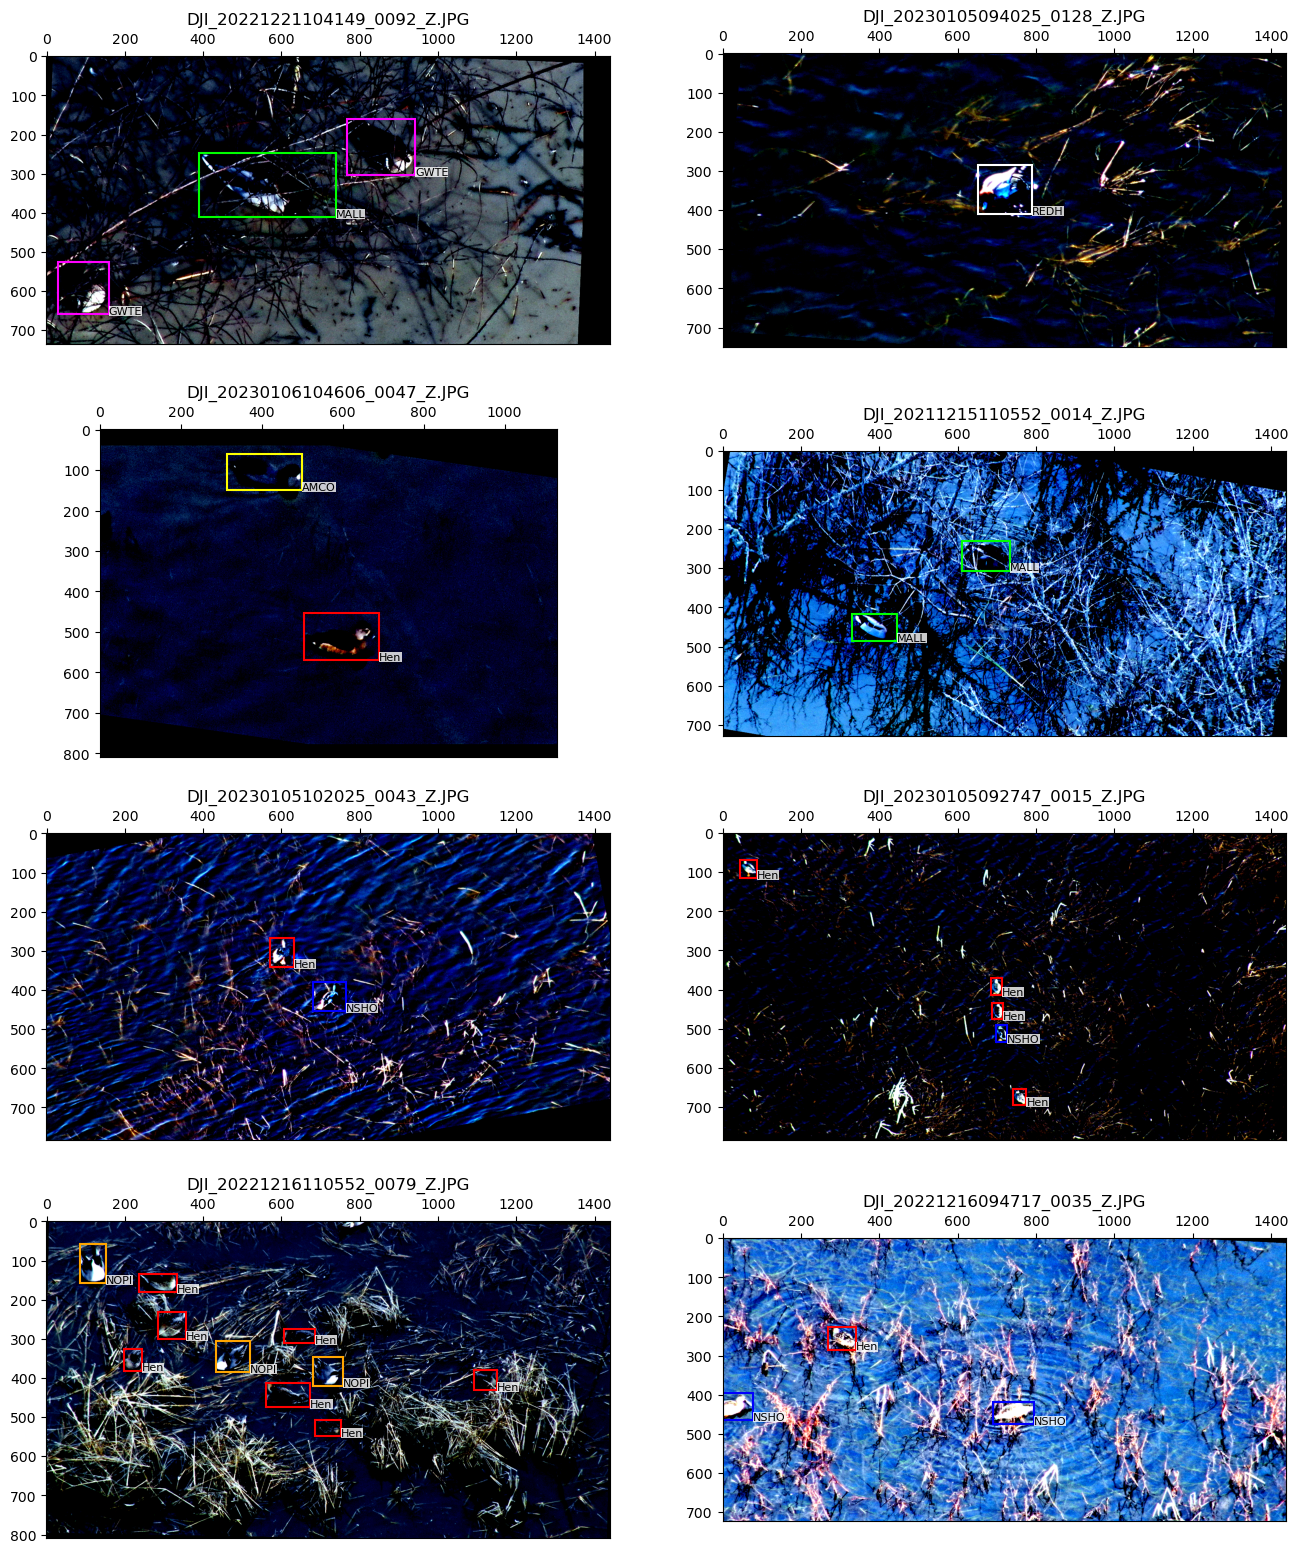

In [11]:
# store images and annotation targets from sample batch
batch = next(iter(sample_data_loader))
images, targets = batch
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

images = [np.clip(image, 0, 1) for image in images]

# Plot all samples from batch in a grid of subplots
plt.figure(figsize=(16, int(sample_data_loader.batch_size) * 5))
for i in range(int(sample_data_loader.batch_size)):
    ax = plt.subplot(int(sample_data_loader.batch_size), 2, 1 + i)
    plot_detections(images[i], targets[i]['boxes'], targets[i]['labels'], ax=ax)
    # Query the dataset to get the image name for the given image_id
    image_id = targets[i]['image_id'].item()  # Convert tensor to integer
    image_name = sample_dataset.unique_image_names[image_id]
    plt.title(image_name)

plt.show()

#### Use stratified sampling to split multi-label dataset into train, val, test sets

In [12]:
from sklearn.model_selection import StratifiedKFold

# Set random number generator for reproducible data splits
rng = np.random.default_rng(np.random.MT19937(np.random.SeedSequence(420)))

# Group annotations by image
image_groups = df.groupby('img_name')

# Create a dictionary to store the class distribution for each image
image_class_distribution = {}

# Populate the dictionary with class distributions
for image_name, group in image_groups:
    labels = group['label'].tolist()
    image_class_distribution[image_name] = labels

# Create a list of all image names and their corresponding labels
all_images = list(image_class_distribution.keys())
all_labels = [image_class_distribution[image] for image in all_images]

# Use the most frequent label for each image for stratification
representative_labels = [max(set(labels), key=labels.count) for labels in all_labels]

# Define the split ratios
train_ratio = 0.8
val_ratio = 0.15
test_ratio = 0.05

# Perform stratified split using StratifiedKFold
skf = StratifiedKFold(n_splits=int(1/test_ratio), shuffle=True, random_state=420)

train_val_indices, test_indices = next(skf.split(all_images, representative_labels))

# Further split train+val into train and validation sets
train_val_images = [all_images[idx] for idx in train_val_indices]
train_val_labels = [representative_labels[idx] for idx in train_val_indices]

skf_val = StratifiedKFold(n_splits=int(1/(val_ratio/(train_ratio + val_ratio))), shuffle=True, random_state=420)
train_indices, val_indices = next(skf_val.split(train_val_images, train_val_labels))

# Map image names to unique indices
image_to_unique_index = {image: idx for idx, image in enumerate(df['img_name'].unique())}

# Create lists of unique indices for each split
train_indices = [image_to_unique_index[train_val_images[idx]] for idx in train_indices]
val_indices = [image_to_unique_index[train_val_images[idx]] for idx in val_indices]
test_indices = [image_to_unique_index[all_images[idx]] for idx in test_indices]

# Function to get class distribution
def get_class_distribution(images, image_class_distribution):
    class_counts = defaultdict(int)
    for image in images:
        for label in image_class_distribution[image]:
            class_counts[label] += 1
    return class_counts

# Get train, val, and test images
train_images = [all_images[idx] for idx in train_indices]
val_images = [all_images[idx] for idx in val_indices]
test_images = [all_images[idx] for idx in test_indices]

train_class_distribution = get_class_distribution(train_images, image_class_distribution)
val_class_distribution = get_class_distribution(val_images, image_class_distribution)
test_class_distribution = get_class_distribution(test_images, image_class_distribution)

class_indices = {label: [] for label in df['label'].unique()}

for idx, row in df.iterrows():
    class_indices[row['label']].append(idx)

train_class_distribution = {k: v / len(class_indices[k]) for k, v in train_class_distribution.items()}
val_class_distribution = {k: v / len(class_indices[k]) for k, v in val_class_distribution.items()}
test_class_distribution = {k: v / len(class_indices[k]) for k, v in test_class_distribution.items()}

print("Train class distribution:", dict(sorted(train_class_distribution.items())))
print("Validation class distribution:", dict(sorted(val_class_distribution.items())))
print("Test class distribution:", dict(sorted(test_class_distribution.items())))

Train class distribution: {1: 0.7746031746031746, 2: 0.7090909090909091, 3: 0.7373737373737373, 4: 0.7980049875311721, 5: 0.7710280373831776, 6: 0.7936360827927093, 7: 0.806615776081425, 8: 0.7945383615084526, 9: 0.8288288288288288, 10: 0.8293650793650794, 11: 0.7940983606557377}
Validation class distribution: {1: 0.16984126984126985, 2: 0.2545454545454545, 3: 0.21212121212121213, 4: 0.16375727348295926, 5: 0.1822429906542056, 6: 0.1600247142415817, 7: 0.13910093299406276, 8: 0.15214564369310793, 9: 0.12252252252252252, 10: 0.13095238095238096, 11: 0.1580327868852459}
Test class distribution: {1: 0.05555555555555555, 2: 0.03636363636363636, 3: 0.050505050505050504, 4: 0.038237738985868665, 5: 0.04672897196261682, 6: 0.04633920296570899, 7: 0.0542832909245123, 8: 0.053315994798439535, 9: 0.04864864864864865, 10: 0.03968253968253968, 11: 0.04786885245901639}


#### Create weighted random sampler to handle class imbalances during training

In [13]:
# Function to calculate class weights dynamically
def calculate_class_weights(labels, hen_label_int, background_label_int):
    # Count the occurrences of each class
    class_counts = Counter(labels)
    
    # Remove the "Hen" class from the counts
    hen_count = class_counts.pop(hen_label_int, None)
    
    # Identify the count for the second most-frequent class
    second_most_frequent_class_count = max(class_counts.values())
    
    # Calculate the weight for the "Hen" class
    hen_weight = second_most_frequent_class_count / hen_count if hen_count else 1.0
    
    # Assign weights to all classes
    class_weights = {label: sum(class_counts.values()) / count for label, count in class_counts.items()}
    
    # Normalize weights to range [1, 2]
    min_weight = min(class_weights.values())
    max_weight = max(class_weights.values())
    class_weights = {label: 1 + (weight - min_weight) / (max_weight - min_weight) for label, weight in class_weights.items()}
    
    # Add weight for the "Hen" class
    class_weights[hen_label_int] = hen_weight

    # Add weight = 5% for the background class
    class_weights[background_label_int] = 0.05
    
    return class_weights

# Store train labels for each image
train_labels = [label for image in train_images for label in image_class_distribution[image]]

# Calculate class weights dynamically
hen_label_int = [key for key, value in label_dict.items() if value == 'Hen'][0]  # Get the integer label for "Hen"
background_label_int = 0  # Assuming background is class 0
class_weights = calculate_class_weights(train_labels, hen_label_int, background_label_int)

# Convert class weights to a list in the correct order
unique_labels = sorted(set(train_labels))
train_class_weights = [class_weights[label] for label in unique_labels]

# Add weight for the background class
train_class_weights = [class_weights[background_label_int]] + train_class_weights  # Background is class 0
train_class_weights = torch.tensor(train_class_weights, dtype=torch.float32)

# print class counts and class weight for each class
print("Train class instances and weights: ")
for label in unique_labels:
    print(f"{label_dict[label]}: count = {train_labels.count(label)}, weight = {train_class_weights[label]}")


# # Calculate sample weights for each image in the training dataset
# train_sample_weights = []
# for image_name in train_images:
#     labels = image_class_distribution[image_name]
#     sample_weight = sum(train_class_weights[label] for label in labels) / len(labels)
#     train_sample_weights.append(sample_weight)

# # Create WeightedRandomSampler
# train_sampler = torch.utils.data.WeightedRandomSampler(weights=train_sample_weights, num_samples=len(train_sample_weights), replacement=True)

Train class instances and weights: 
AMCO: count = 488, weight = 1.049301028251648
AMWI: count = 39, weight = 2.0
BUFF: count = 73, weight = 1.5187479257583618
GADW: count = 960, weight = 1.0087003707885742
GWTE: count = 660, weight = 1.0277807712554932
Hen: count = 2569, weight = 0.47138965129852295
MALL: count = 951, weight = 1.009097695350647
NOPI: count = 611, weight = 1.032677412033081
NSHO: count = 460, weight = 1.054327368736267
REDH: count = 209, weight = 1.1595358848571777
RNDU: count = 1211, weight = 1.0


#### Configure Custom RetinaNet with ResNet FPN

In [14]:
import torch
import torch.nn as nn
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.retinanet import RetinaNetClassificationHead, RetinaNetRegressionHead
from torchvision.models.detection.anchor_utils import AnchorGenerator
from typing import Optional, Callable, List
from torchvision.ops import sigmoid_focal_loss, FrozenBatchNorm2d

def _sum(x: List[torch.Tensor]) -> torch.Tensor:
    res = x[0]
    for i in x[1:]:
        res = res + i
    return res

class CustomRetinaNetClassificationHead(RetinaNetClassificationHead):
    def __init__(self, in_channels, num_anchors, num_classes, alpha=0.25, gamma_loss=2.0, prior_probability=0.01, norm_layer: Optional[Callable[..., nn.Module]] = None, dropout_prob=0.25, class_weights=None):
        super().__init__(in_channels, num_anchors, num_classes, prior_probability, norm_layer)
        self.alpha = alpha
        self.gamma_loss = gamma_loss
        self.dropout = nn.Dropout(p=dropout_prob)
        self.class_weights = class_weights

    def compute_loss(self, targets, head_outputs, matched_idxs):
        losses = []

        cls_logits = head_outputs["cls_logits"]

        for i, (targets_per_image, cls_logits_per_image, matched_idxs_per_image) in enumerate(zip(targets, cls_logits, matched_idxs)):
            # determine only the foreground
            foreground_idxs_per_image = matched_idxs_per_image >= 0
            num_foreground = foreground_idxs_per_image.sum()

            # create the target classification
            gt_classes_target = torch.zeros_like(cls_logits_per_image)
            gt_classes_target[
                foreground_idxs_per_image,
                targets_per_image["labels"][matched_idxs_per_image[foreground_idxs_per_image]],
            ] = 1.0

            # find indices for which anchors should be ignored
            valid_idxs_per_image = matched_idxs_per_image != self.BETWEEN_THRESHOLDS

            # get the class weights for the valid indices
            if self.class_weights is not None:
                valid_labels = targets_per_image["labels"][matched_idxs_per_image[valid_idxs_per_image]]
                weights = self.class_weights.to(valid_labels.device)[valid_labels]
            else:
                weights = torch.ones_like(valid_idxs_per_image, dtype=torch.float32)

            # compute the classification loss with custom alpha, gamma_loss, and class weights
            losses.append(
                (sigmoid_focal_loss(
                    cls_logits_per_image[valid_idxs_per_image],
                    gt_classes_target[valid_idxs_per_image],
                    alpha=self.alpha,
                    gamma=self.gamma_loss,
                    reduction="none",
                ) * weights.unsqueeze(1)).sum() / max(1, num_foreground)
            )

        return _sum(losses) / len(targets)
    
    def forward(self, x):
        all_cls_logits = []
        for features in x:
            cls_logits = self.conv(features)
            cls_logits = self.dropout(cls_logits)  # Apply dropout
            cls_logits = self.cls_logits(cls_logits)

            # Permute classification output from (N, A * K, H, W) to (N, HWA, K).
            N, _, H, W = cls_logits.shape
            cls_logits = cls_logits.view(N, -1, self.num_classes, H, W)
            cls_logits = cls_logits.permute(0, 3, 4, 1, 2)
            cls_logits = cls_logits.reshape(N, -1, self.num_classes)  # Size=(N, HWA, K)

            all_cls_logits.append(cls_logits)


        return torch.cat(all_cls_logits, dim=1)

class CustomRetinaNetRegressionHead(RetinaNetRegressionHead):
    def __init__(self, in_channels, num_anchors, norm_layer: Optional[Callable[..., nn.Module]] = None, dropout_prob=0.25):
        super().__init__(in_channels, num_anchors, norm_layer)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        all_bbox_regression = []
        for features in x:
            bbox_regression = self.conv(features)
            bbox_regression = self.dropout(bbox_regression)  # Apply dropout
            bbox_regression = self.bbox_reg(bbox_regression)

            # Permute bbox regression output from (N, 4 * A, H, W) to (N, HWA, 4).
            N, _, H, W = bbox_regression.shape
            bbox_regression = bbox_regression.view(N, -1, 4, H, W)
            bbox_regression = bbox_regression.permute(0, 3, 4, 1, 2)
            bbox_regression = bbox_regression.reshape(N, -1, 4)  # Size=(N, HWA, 4)

            all_bbox_regression.append(bbox_regression)

        return torch.cat(all_bbox_regression, dim=1)

def get_retinanet_model(depth, num_classes=12, min_size=810, max_size=1440, image_mean=[0, 0, 0], image_std=[1, 1, 1], score_thresh=0.1, nms_thresh=0.4, 
                        detections_per_img=150, fg_iou_thresh=0.6, bg_iou_thresh=0.4, topk_candidates=500, alpha=0.75,
                        gamma_loss=3.0, trainable_backbone_layers=4, dropout_prob=0.25, class_weights=None):
    # Create the backbone with FPN
    if depth == 18:
        backbone = resnet_fpn_backbone(backbone_name='resnet18', 
                                       weights=torchvision.models.ResNet18_Weights.DEFAULT, 
                                       trainable_layers=trainable_backbone_layers
                                       )
    elif depth == 34:
        backbone = resnet_fpn_backbone(backbone_name='resnet34', 
                                       weights=torchvision.models.ResNet34_Weights.DEFAULT,
                                       trainable_layers=trainable_backbone_layers
                                       )
    elif depth == 50:
        backbone = resnet_fpn_backbone(backbone_name='resnet50', 
                                       weights=torchvision.models.ResNet50_Weights.DEFAULT,
                                       trainable_layers=trainable_backbone_layers
                                       )
    elif depth == 101:
        backbone = resnet_fpn_backbone(backbone_name='resnet101', 
                                       weights=torchvision.models.ResNet101_Weights.DEFAULT, 
                                       trainable_layers=trainable_backbone_layers
                                       )
    elif depth == 152:
        backbone = resnet_fpn_backbone(backbone_name='resnet152', 
                                       weights=torchvision.models.ResNet152_Weights.DEFAULT, 
                                       trainable_layers=trainable_backbone_layers
                                       )
    else:
        raise ValueError("Unsupported model depth")

    # Create the RetinaNet model with the custom backbone
    model = RetinaNet(backbone, 
                      num_classes=num_classes,
                      min_size=min_size, # same size as resize in transform to keep aspect ratio
                      max_size=max_size,
                      image_mean=image_mean,
                      image_std=image_std,
                      score_thresh=score_thresh, 
                      nms_thresh=nms_thresh, 
                      detections_per_img=detections_per_img,
                      fg_iou_thresh=fg_iou_thresh,
                      bg_iou_thresh=bg_iou_thresh,
                      topk_candidates=topk_candidates
                      )

    # Replace the classification head with the custom one
    in_channels = model.head.classification_head.cls_logits.in_channels
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head = CustomRetinaNetClassificationHead(in_channels, 
                                                                       num_anchors, 
                                                                       num_classes, 
                                                                       alpha=alpha, 
                                                                       gamma_loss=gamma_loss, 
                                                                       dropout_prob=dropout_prob,
                                                                       class_weights=class_weights)

    # Replace the regression head with the custom one
    model.head.regression_head = CustomRetinaNetRegressionHead(in_channels, num_anchors, dropout_prob=dropout_prob)
    
    model.anchor_generator = AnchorGenerator(sizes=((16, 32, 53), (32, 65, 107), (64, 130, 214), (128, 261, 428), (256, 522, 856)), 
                                             aspect_ratios=((0.9, 1.7, 2.6), (0.9, 1.7, 2.6), (0.9, 1.7, 2.6), (0.9, 1.7, 2.6), (0.9, 1.7, 2.6)))
    
    # replace FrozenBatchNorm2d in the last two backbone layers with trainable batchNorm2d
    for name, module in model.backbone.body.named_modules():
        if 'layer3' in name or 'layer4' in name:
            if isinstance(module, FrozenBatchNorm2d):
                # Extract the number of features, mean, and variance from the FrozenBatchNorm2d
                num_features = module.weight.shape[0]  # Get the number of channels (features)
                running_mean = module.running_mean.clone()  # Extract running mean
                running_var = module.running_var.clone()    # Extract running variance

                # Create a new BatchNorm2d layer with the same number of features
                batch_norm = nn.BatchNorm2d(num_features)

                # Initialize BatchNorm2d with the extracted running mean and variance
                batch_norm.running_mean = running_mean
                batch_norm.running_var = running_var

                # Initialize the weights with a normal distribution (mean=1, std=0.02) for stability
                nn.init.normal_(batch_norm.weight, mean=1.0, std=0.02)  # Small normal distribution

                # Initialize the biases to zero (standard for BatchNorm2d)
                nn.init.constant_(batch_norm.bias, 0)

                # Replace the FrozenBatchNorm2d layer with BatchNorm2d
                parent_module_name = '.'.join(name.split('.')[:-1])  # Get the parent module name
                module_name = name.split('.')[-1]  # Extract the last part of the name (the module name)

                # Retrieve the parent module and replace the FrozenBatchNorm2d with BatchNorm2d
                parent_module = dict(model.backbone.body.named_modules())[parent_module_name]
                setattr(parent_module, module_name, batch_norm)

                # Set requires_grad to True for the new BatchNorm2d layer
                for param in batch_norm.parameters():
                    param.requires_grad = True

    return model

In [15]:
print(get_retinanet_model(depth=34))

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), s

### <center>**Tune Model Hyperparameters using Ray Tune**</center> 

##### Class for tuning RetinaNet

In [ ]:
import ray
from ray import tune, train
from ray.tune.schedulers import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
from ray.tune.search import ConcurrencyLimiter
from datetime import datetime
import torch
import torchvision
import gc
import tempfile
from pathlib import Path
import ray.cloudpickle as pickle
from concurrent.futures import ThreadPoolExecutor
import random
from torch_lr_finder import LRFinder, TrainDataLoaderIter

from engine_gradientAccumulation import train_one_epoch, evaluate
from coco_utils import get_coco_api_from_dataset

# Set random seed for reproducible training
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)


class RetinaNetTuner:
    def __init__(self, num_samples, max_num_epochs, restore_path=""):
        self.num_samples = num_samples
        self.max_num_epochs = max_num_epochs
        self.restore_path = restore_path

    def create_coco_datasets(self, train_dataset, val_dataset, test_dataset):
        with ThreadPoolExecutor(max_workers=3) as executor:
            train_future = executor.submit(get_coco_api_from_dataset, train_dataset)
            val_future = executor.submit(get_coco_api_from_dataset, val_dataset)
            test_future = executor.submit(get_coco_api_from_dataset, test_dataset)
            train_coco_ds = train_future.result()
            val_coco_ds = val_future.result()
            test_coco_ds = test_future.result()
        return train_coco_ds, val_coco_ds, test_coco_ds
    
    def train_lr_finder(self, config):
        class CustomTrainDataLoaderIter(TrainDataLoaderIter):
            def inputs_labels_from_batch(self, batch_data):
                inputs = [image.to('cuda:0') for image in batch_data[0]]
                labels = [{k: v.to('cuda:0') for k, v in t.items()} for t in batch_data[1]]
                return inputs, labels

        dataset_train = ray.get(config["dataset_train_ref"])
        accumulation_steps = 1  ## FIXME: hardcoded for now

        data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=config["batch_size"],
                                                        # sampler=config["train_sampler"],
                                                        shuffle=True,
                                                        collate_fn=utils.collate_fn,
                                                        num_workers=0, pin_memory=True)

        model = get_retinanet_model(
            depth=config["resnet"],
            num_classes=len(config["class_weights"]),
            score_thresh=config["score_thresh"],
            nms_thresh=config["nms_thresh"],
            detections_per_img=150,
            fg_iou_thresh=0.6,
            bg_iou_thresh=0.4,
            topk_candidates=500,
            alpha=config["alpha"],
            gamma_loss=config["gamma_loss"],
            trainable_backbone_layers=int(config["backbone_lyrs"]),
            dropout_prob=config["dropout"],
            class_weights=config["class_weights"]
        ).to('cuda:0')

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(
            params, lr=1e-7, momentum=config["momentum"], weight_decay=config["weight_decay"]
        )

        train_iter = CustomTrainDataLoaderIter(data_loader_train)
        grad_scaler = torch.GradScaler()

        class CustomLRFinder(LRFinder):
            def __init__(self, model, optimizer, criterion, device=None, amp_backend="native", amp_config=None, grad_scaler=None):
                super().__init__(model, optimizer, criterion, device)
                self.amp_backend = amp_backend
                self.amp_config = amp_config
                self.grad_scaler = grad_scaler or torch.GradScaler()

            def _train_batch(self, train_iter, accumulation_steps, non_blocking_transfer=True):
                self.model.train()
                total_loss = 0

                self.optimizer.zero_grad()
                for _ in range(accumulation_steps):
                    inputs, labels = next(train_iter)
                    inputs, labels = self._move_to_device(inputs, labels, non_blocking=non_blocking_transfer)

                    with torch.autocast(device_type="cuda:0"):
                        outputs = self.model(inputs, labels)
                        loss = sum(loss for loss in outputs.values())

                    loss /= accumulation_steps
                    self.grad_scaler.scale(loss).backward()
                    total_loss += loss

                self.grad_scaler.step(self.optimizer)
                self.grad_scaler.update()

                return total_loss.item()

        lr_finder = CustomLRFinder(model, optimizer, None, device='cuda:0', amp_backend='torch', amp_config=None, grad_scaler=grad_scaler)
        lr_finder.range_test(train_iter, end_lr=1, num_iter=len(data_loader_train), step_mode='exp', accumulation_steps=accumulation_steps) # num_iter = len(dataloader) to sample from full train dataset
        suggested_lr = lr_finder.plot(suggest_lr=True)

        lr_finder.reset()

        # return default if torch lr finder fails
        try:
            if isinstance(suggested_lr, tuple):
                axes, suggested_lr_value = suggested_lr
                return suggested_lr_value
            else:
                raise ValueError(f"Unexpected return type from plot method: {type(suggested_lr)}")
        except ValueError as e:
            print(f"Error during learning rate finding: {e}")
            # Return a default learning rate if an error occurs
            return 5e-4

    def train_MAVdroneDataset(self, config):

        set_seed(420)

        dataset_train = ray.get(config["dataset_train_ref"])
        data_loader_val = ray.get(config["data_loader_val_ref"])
        train_coco_ds = ray.get(config["train_coco_ds_ref"])
        val_coco_ds = ray.get(config["val_coco_ds_ref"])

        training_steps = [
            {"step": 0, "batch_size": config["batch_size"], "epochs": 15, "print_freq": 25, "accumulation_steps": 1},
            {"step": 1, "batch_size": config["batch_size"], "epochs": 13, "print_freq": 25, "accumulation_steps": 2},
            {"step": 2, "batch_size": config["batch_size"], "epochs": 12, "print_freq": 25, "accumulation_steps": 4},
            {"step": 3, "batch_size": config["batch_size"], "epochs": 10, "print_freq": 25, "accumulation_steps": 8}
        ]

        checkpoint = train.get_checkpoint()
        if checkpoint:
            with checkpoint.as_directory() as checkpoint_dir:
                data_path = Path(checkpoint_dir) / "data.pkl"
                with open(data_path, "rb") as fp:
                    checkpoint_state = pickle.load(fp)
                start_epoch = checkpoint_state["epoch"] + 1
                current_step = checkpoint_state["current_step"]
                batch_size = checkpoint_state["batch_size"]
                accumulation_steps = checkpoint_state["accumulation_steps"]
        else:
            start_epoch = 0
            current_step = 0
            batch_size = config["batch_size"]
            accumulation_steps = training_steps[0]["accumulation_steps"]

        step_index = current_step

        while step_index < len(training_steps):
            step = training_steps[step_index]
            batch_size = step['batch_size']
            total_epochs = step['epochs']
            print_freq = step['print_freq']
            accumulation_steps = step['accumulation_steps']
            effective_bs = batch_size * accumulation_steps

            # scale the learning rate with batch size increases
            base_bs = training_steps[0]['batch_size'] * training_steps[0]['accumulation_steps']
            scaled_lr = config["lr"] * (effective_bs / base_bs)


            model = get_retinanet_model(depth=config["resnet"],
                                        num_classes=len(config["class_weights"]),
                                        score_thresh=config["score_thresh"],
                                        nms_thresh=config["nms_thresh"],
                                        detections_per_img=150,
                                        fg_iou_thresh=0.6,
                                        bg_iou_thresh=0.4,
                                        topk_candidates=500,
                                        alpha=config["alpha"],
                                        gamma_loss=config["gamma_loss"],
                                        trainable_backbone_layers=int(config["backbone_lyrs"]),
                                        dropout_prob=config["dropout"],
                                        class_weights=config["class_weights"])

            device = "cpu"
            if torch.cuda.is_available():
                device = "cuda:0"
            model.to(device)

            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

            params = [p for p in model.parameters() if p.requires_grad]
            optimizer = torch.optim.SGD(params, lr=scaled_lr,
                                        momentum=config["momentum"],
                                        weight_decay=config["weight_decay"])

            lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

            if checkpoint:
                model.load_state_dict(checkpoint_state["model_state_dict"])
                optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])

            remaining_epochs = total_epochs - (start_epoch % total_epochs)

            data_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                                    #   sampler=config["train_sampler"],
                                                      shuffle=True,
                                                      collate_fn=utils.collate_fn,
                                                      num_workers=0, pin_memory=True)

            print(f'Training step: {step["step"]}, effective batch size: {batch_size * accumulation_steps}, scaled lr: {scaled_lr:.6f}')
            print()

            for epoch in range(start_epoch, start_epoch + remaining_epochs):
                train_metric_logger, val_metric_logger = train_one_epoch(model, optimizer, data_loader, device,
                                                                         epoch, print_freq, accumulation_steps,
                                                                         data_loader_val)

                train_coco_evaluator, val_coco_evaluator = evaluate(model, data_loader_val, val_coco_ds, device, data_loader, train_coco_ds)

                lr_scheduler.step(metrics=val_metric_logger.loss.avg)

                checkpoint_data = {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "current_step": step["step"],
                    "batch_size": batch_size,
                    "accumulation_steps": accumulation_steps,
                }

                with tempfile.TemporaryDirectory() as checkpoint_dir:
                    data_path = Path(checkpoint_dir) / "data.pkl"
                    with open(data_path, "wb") as fp:
                        pickle.dump(checkpoint_data, fp)
                    train.report(
                        {"epoch": epoch,
                         "train_loss": train_metric_logger.loss.avg,
                         "val_loss": val_metric_logger.loss.avg,
                         "train_mAP": train_coco_evaluator.coco_eval['bbox'].stats[0],
                         "val_mAP": val_coco_evaluator.coco_eval['bbox'].stats[0],
                         "train_mAR": train_coco_evaluator.coco_eval['bbox'].stats[8],
                         "val_mAR": val_coco_evaluator.coco_eval['bbox'].stats[8],
                         "train_f1": calculate_f1_score(train_coco_evaluator.coco_eval['bbox'].stats[0],
                                                        train_coco_evaluator.coco_eval['bbox'].stats[8]),
                         "val_f1": calculate_f1_score(val_coco_evaluator.coco_eval['bbox'].stats[0],
                                                      val_coco_evaluator.coco_eval['bbox'].stats[8])},
                        checkpoint=train.Checkpoint.from_directory(checkpoint_dir),
                    )

            start_epoch += remaining_epochs

            step_index += 1

        print('Tuning Trial Complete!')

    def trial_dirname_creator(self, trial):
        return f"{trial.trial_id}"

    def run(self):
        ray.shutdown()
        ray.init()

        dataset = MAVdroneDataset(
            csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
            root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
            transforms=get_transform(train=True)
        )

        dataset_val = MAVdroneDataset(
            csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
            root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
            transforms=get_transform(train=False)
        )

        dataset_test = MAVdroneDataset(
            csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
            root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
            transforms=get_transform(train=False)
        )

        dataset_train = torch.utils.data.Subset(dataset, train_indices)
        dataset_val = torch.utils.data.Subset(dataset_val, val_indices)
        dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

        data_loader_val = torch.utils.data.DataLoader(
            dataset_val, batch_size=1, shuffle=False,
            collate_fn=utils.collate_fn, num_workers=0, pin_memory=True
        )

        data_loader_test = torch.utils.data.DataLoader(
            dataset_test, batch_size=1, shuffle=False,
            collate_fn=utils.collate_fn, num_workers=0, pin_memory=True
        )

        train_coco_ds, val_coco_ds, test_coco_ds = self.create_coco_datasets(dataset_train, dataset_val, dataset_test)

        dataset_train_ref = ray.put(dataset_train)
        data_loader_val_ref = ray.put(data_loader_val)
        data_loader_test_ref = ray.put(data_loader_test)
        train_coco_ds_ref = ray.put(train_coco_ds)
        val_coco_ds_ref = ray.put(val_coco_ds)
        test_coco_ds_ref = ray.put(test_coco_ds)

        config = {
            # "lr": tune.sample_from(lambda config: self.train_lr_finder(config)),
            "lr": tune.loguniform(0.0001, 0.01),
            "resnet": tune.choice([34, 50]),
            "momentum": tune.uniform(0.5, 0.9),
            "weight_decay": tune.loguniform(0.00001, 0.005),
            "alpha": tune.uniform(0.3, 0.9),
            "gamma_loss": tune.uniform(2.0, 4.0),
            "backbone_lyrs": tune.choice([3, 4, 5]),
            "batch_size": tune.choice([4, 8]),
            "dropout": tune.uniform(0.2, 0.6),
            "score_thresh": tune.uniform(0.25, 0.75),
            "nms_thresh": tune.uniform(0.05, 0.35),
            "dataset_train_ref": dataset_train_ref,
            "data_loader_val_ref": data_loader_val_ref,
            "data_loader_test_ref": data_loader_test_ref,
            "train_coco_ds_ref": train_coco_ds_ref,
            "val_coco_ds_ref": val_coco_ds_ref,
            "test_coco_ds_ref": test_coco_ds_ref,
            # "train_sampler": train_sampler,
            "class_weights": train_class_weights
        }

        if tune.Tuner.can_restore(os.path.abspath(self.restore_path)):
            tuner = tune.Tuner.restore(
                os.path.abspath(self.restore_path),
                trainable=self.train_MAVdroneDataset,
                param_space=config,
                resume_unfinished=True,
                resume_errored=False
            )
            print(f"Tuner Restored from {self.restore_path}")
        else:
            algo = TuneBOHB(
                points_to_evaluate=[
                     {"lr": 0.0018174272508271936,
                     "resnet": 50,
                     "momentum": 0.641007483166926,
                     "weight_decay": 1.7737466760404307e-05,
                     "alpha": 0.4893875487532765,
                     "gamma_loss": 3.736332958570757,
                     "backbone_lyrs": 4,
                     "batch_size": 4,
                     "dropout": 0.24357127281473448,
                     "score_thresh": 0.3394643439588512,
                     "nms_thresh": 0.22026127980940127
                     }
                ],
                seed=420
            )

            algo = ConcurrencyLimiter(algo, max_concurrent=1)

            scheduler = HyperBandForBOHB(
                time_attr="training_iteration",
                max_t=int(self.max_num_epochs),
                reduction_factor=4,
                stop_last_trials=False,
            )

            reporter = tune.JupyterNotebookReporter(overwrite=True,
                metric_columns=["epoch", "train_loss", "val_loss", "train_mAP", "val_mAP", "train_mAR", "val_mAR", "train_f1", "val_f1"],
                parameter_columns=["lr", "resnet", "momentum", "weight_decay", "alpha", "gamma_loss", "backbone_lyrs", "batch_size", "dropout", "score_thresh", "nms_thresh"],
                print_intermediate_tables=True,
                sort_by_metric=True
            )

            tuner = tune.Tuner(
                tune.with_resources(
                    self.train_MAVdroneDataset,
                    resources={"cpu": 24.0, "gpu": 1.0}
                ),
                run_config=train.RunConfig(
                    name=f"BOHB_RetinaNet_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
                    failure_config=train.FailureConfig(max_failures=1),
                    progress_reporter=reporter,
                ),
                tune_config=tune.TuneConfig(
                    mode="min",
                    metric="val_loss",
                    search_alg=algo,
                    scheduler=scheduler,
                    num_samples=int(self.num_samples),
                    trial_dirname_creator=self.trial_dirname_creator
                ),
                param_space=config
            )
        results = tuner.fit()

        best_trial = results.get_best_result("val_f1", "max")

        print("Best trial config: {}".format(best_trial.config))
        print()
        print("Best trial final training loss: {}".format(best_trial.metrics["train_loss"]))
        print("Best trial final validation loss: {}".format(best_trial.metrics["val_loss"]))
        print("Best trial final training mAP: {}".format(best_trial.metrics["train_mAP"]))
        print("Best trial final validation mAP: {}".format(best_trial.metrics["val_mAP"]))
        print("Best trial final training mAR: {}".format(best_trial.metrics["train_mAR"]))
        print("Best trial final validation mAR: {}".format(best_trial.metrics["val_mAR"]))
        print("Best trial final training f1-score: {}".format(best_trial.metrics["train_f1"]))
        print("Best trial final validation f1-score: {}".format(best_trial.metrics["val_f1"]))
        
        print()

        best_checkpoint = best_trial.get_best_checkpoint(metric="val_f1", mode="max")

        self.test_best_model(best_trial, best_checkpoint)

        return train_coco_ds, val_coco_ds, test_coco_ds, results, best_trial

    def test_best_model(self, best_trial, best_checkpoint):
        best_model = get_retinanet_model(depth=best_trial.config["resnet"],
                                         num_classes=len(best_trial.config["class_weights"]),
                                         score_thresh=best_trial.config["score_thresh"],
                                         nms_thresh=best_trial.config["nms_thresh"],
                                         detections_per_img=150,
                                         fg_iou_thresh=0.6,
                                         bg_iou_thresh=0.4,
                                         topk_candidates=500,
                                         alpha=best_trial.config["alpha"],
                                         gamma_loss=best_trial.config["gamma_loss"],
                                         trainable_backbone_layers=int(best_trial.config["backbone_lyrs"]),
                                         dropout_prob=best_trial.config["dropout"],
                                         class_weights=None)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        best_model.to(device)

        with best_checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                best_checkpoint_data = pickle.load(fp)
            best_model.load_state_dict(best_checkpoint_data["model_state_dict"])

        data_loader_test = ray.get(best_trial.config["data_loader_test_ref"])
        test_coco_ds = ray.get(best_trial.config["test_coco_ds_ref"])

        test_results = evaluate(best_model, data_loader_test, test_coco_ds, device, train_data_loader=None, train_coco_ds=None)

        print(f'Best trial test set mAP: {test_results.coco_eval["bbox"].stats[0]}')
        print(f'Best trial test set mAR: {test_results.coco_eval["bbox"].stats[8]}')
        print(f'Best trial test set f1-score: {calculate_f1_score(test_results.coco_eval["bbox"].stats[0], test_results.coco_eval["bbox"].stats[8])}')

if __name__ == "__main__":
    torch.cuda.empty_cache()
    gc.collect()

    trainer = RetinaNetTuner(num_samples=50, max_num_epochs=50, restore_path="C:/Users/exx/ray_results/FALSE")
    train_coco_ds, val_coco_ds, test_coco_ds, results, best_trial = trainer.run()

2025-01-29 15:38:09,263	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(_trainable pid=33524) Training step: 0, effective batch size: 4, scaled lr: 0.001817
(_trainable pid=33524) 
(_trainable pid=33524) Epoch: [0] Training  [  0/372]  eta: 0:23:14  lr: 0.000007  loss: 2.4191 (2.4191)  classification: 1.7992 (1.7992)  bbox_regression: 0.6199 (0.6199)  time: 3.7495  data: 2.7112  max mem: 9988
(_trainable pid=33524) Epoch: [0] Training  [ 25/372]  eta: 0:15:50  lr: 0.000129  loss: 2.4719 (2.5731)  classification: 1.9632 (1.9692)  bbox_regression: 0.5583 (0.6039)  time: 2.7646  data: 2.3423  max mem: 9988
(_trainable pid=33524) Epoch: [0] Training  [ 50/372]  eta: 0:15:02  lr: 0.000251  loss: 2.4632 (2.5348)  classification: 1.9082 (1.9473)  bbox_regression: 0.5317 (0.5875)  time: 2.9367  data: 2.5047  max mem: 9988
(_trainable pid=33524) Epoch: [0] Training  [ 75/372]  eta: 0:13:33  lr: 0.000374  loss: 2.4916 (2.5295)  classification: 1.9603 (1.9526)  bbox_regression: 0.5313 (0.5769)  time: 2.6909  data: 2.2849  max mem: 9988
(_trainable pid=33524) Epoch: 

(_trainable pid=33524) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/93cefdb8/checkpoint_000000)


(_trainable pid=33524) Epoch: [1] Training  [  0/372]  eta: 0:17:38  lr: 0.001817  loss: 1.6242 (1.6242)  classification: 1.1538 (1.1538)  bbox_regression: 0.4704 (0.4704)  time: 2.8447  data: 2.2379  max mem: 10464
(_trainable pid=33524) Epoch: [1] Training  [ 25/372]  eta: 0:16:26  lr: 0.001817  loss: 1.2944 (1.3729)  classification: 0.8165 (0.9027)  bbox_regression: 0.4443 (0.4702)  time: 2.8278  data: 2.3975  max mem: 10464
(_trainable pid=33524) Epoch: [1] Training  [ 50/372]  eta: 0:14:56  lr: 0.001817  loss: 1.1481 (1.3258)  classification: 0.6834 (0.8561)  bbox_regression: 0.4535 (0.4696)  time: 2.7691  data: 2.3515  max mem: 10464
(_trainable pid=33524) Epoch: [1] Training  [ 75/372]  eta: 0:13:35  lr: 0.001817  loss: 1.0734 (1.2808)  classification: 0.6054 (0.8088)  bbox_regression: 0.4639 (0.4721)  time: 2.6787  data: 2.2687  max mem: 10464
(_trainable pid=33524) Epoch: [1] Training  [100/372]  eta: 0:12:34  lr: 0.001817  loss: 1.5104 (1.3495)  classification: 1.0303 (0.8754

(_trainable pid=33524) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/93cefdb8/checkpoint_000001)


(_trainable pid=33524) Epoch: [2] Training  [  0/372]  eta: 0:22:24  lr: 0.001817  loss: 1.0398 (1.0398)  classification: 0.7019 (0.7019)  bbox_regression: 0.3380 (0.3380)  time: 3.6137  data: 3.0252  max mem: 11016
(_trainable pid=33524) Epoch: [2] Training  [ 25/372]  eta: 0:16:28  lr: 0.001817  loss: 0.9957 (1.0462)  classification: 0.6439 (0.6706)  bbox_regression: 0.3568 (0.3756)  time: 2.8576  data: 2.4417  max mem: 11016
(_trainable pid=33524) Epoch: [2] Training  [ 50/372]  eta: 0:14:38  lr: 0.001817  loss: 0.8298 (0.9456)  classification: 0.4437 (0.5730)  bbox_regression: 0.3637 (0.3726)  time: 2.5767  data: 2.1829  max mem: 11016
(_trainable pid=33524) Epoch: [2] Training  [ 75/372]  eta: 0:13:33  lr: 0.001817  loss: 0.7950 (0.9147)  classification: 0.4339 (0.5360)  bbox_regression: 0.4002 (0.3787)  time: 2.8034  data: 2.3870  max mem: 11016
(_trainable pid=33524) Epoch: [2] Training  [100/372]  eta: 0:12:20  lr: 0.001817  loss: 0.8255 (0.8877)  classification: 0.4625 (0.5139

(_trainable pid=33524) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/93cefdb8/checkpoint_000002)


(_trainable pid=49372) Training step: 0, effective batch size: 4, scaled lr: 0.001817
(_trainable pid=49372) 
(_trainable pid=49372) Epoch: [0] Training  [  0/372]  eta: 0:23:15  lr: 0.000007  loss: 2.4191 (2.4191)  classification: 1.7992 (1.7992)  bbox_regression: 0.6199 (0.6199)  time: 3.7519  data: 2.7204  max mem: 9988
(_trainable pid=49372) Epoch: [0] Training  [ 25/372]  eta: 0:15:58  lr: 0.000129  loss: 2.4719 (2.5731)  classification: 1.9632 (1.9692)  bbox_regression: 0.5583 (0.6039)  time: 2.7786  data: 2.3724  max mem: 9988
(_trainable pid=49372) Epoch: [0] Training  [ 50/372]  eta: 0:15:05  lr: 0.000251  loss: 2.4632 (2.5348)  classification: 1.9082 (1.9473)  bbox_regression: 0.5317 (0.5875)  time: 2.9383  data: 2.5073  max mem: 9988
(_trainable pid=49372) Epoch: [0] Training  [ 75/372]  eta: 0:13:35  lr: 0.000374  loss: 2.4916 (2.5295)  classification: 1.9603 (1.9526)  bbox_regression: 0.5313 (0.5769)  time: 2.6892  data: 2.2775  max mem: 9988
(_trainable pid=49372) Epoch: 

(_trainable pid=49372) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/2260eb6b/checkpoint_000000)


(_trainable pid=49372) Epoch: [1] Training  [  0/372]  eta: 0:17:38  lr: 0.001817  loss: 1.6242 (1.6242)  classification: 1.1538 (1.1538)  bbox_regression: 0.4704 (0.4704)  time: 2.8442  data: 2.3448  max mem: 10464
(_trainable pid=49372) Epoch: [1] Training  [ 25/372]  eta: 0:16:42  lr: 0.001817  loss: 1.2944 (1.3729)  classification: 0.8165 (0.9027)  bbox_regression: 0.4443 (0.4702)  time: 2.8783  data: 2.4634  max mem: 10464
(_trainable pid=49372) Epoch: [1] Training  [ 50/372]  eta: 0:15:14  lr: 0.001817  loss: 1.1481 (1.3258)  classification: 0.6834 (0.8561)  bbox_regression: 0.4535 (0.4696)  time: 2.8391  data: 2.4208  max mem: 10464
(_trainable pid=49372) Epoch: [1] Training  [ 75/372]  eta: 0:13:51  lr: 0.001817  loss: 1.0734 (1.2808)  classification: 0.6054 (0.8088)  bbox_regression: 0.4639 (0.4721)  time: 2.7287  data: 2.3119  max mem: 10464
(_trainable pid=49372) Epoch: [1] Training  [100/372]  eta: 0:12:50  lr: 0.001817  loss: 1.5104 (1.3495)  classification: 1.0303 (0.8754

(_trainable pid=49372) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/2260eb6b/checkpoint_000001)


(_trainable pid=49372) Epoch: [2] Training  [  0/372]  eta: 0:23:04  lr: 0.001817  loss: 1.0398 (1.0398)  classification: 0.7019 (0.7019)  bbox_regression: 0.3380 (0.3380)  time: 3.7216  data: 3.1054  max mem: 11016
(_trainable pid=49372) Epoch: [2] Training  [ 25/372]  eta: 0:16:24  lr: 0.001817  loss: 0.9957 (1.0462)  classification: 0.6439 (0.6706)  bbox_regression: 0.3568 (0.3756)  time: 2.8573  data: 2.4365  max mem: 11016
(_trainable pid=49372) Epoch: [2] Training  [ 50/372]  eta: 0:14:40  lr: 0.001817  loss: 0.8298 (0.9456)  classification: 0.4437 (0.5730)  bbox_regression: 0.3637 (0.3726)  time: 2.5896  data: 2.2013  max mem: 11016
(_trainable pid=49372) Epoch: [2] Training  [ 75/372]  eta: 0:13:33  lr: 0.001817  loss: 0.7950 (0.9147)  classification: 0.4339 (0.5360)  bbox_regression: 0.4002 (0.3787)  time: 2.7891  data: 2.3768  max mem: 11016
(_trainable pid=49372) Epoch: [2] Training  [100/372]  eta: 0:12:19  lr: 0.001817  loss: 0.8255 (0.8877)  classification: 0.4625 (0.5139

(_trainable pid=49372) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/2260eb6b/checkpoint_000002)


(_trainable pid=62280) Training step: 0, effective batch size: 4, scaled lr: 0.000512
(_trainable pid=62280) 
(_trainable pid=62280) Epoch: [0] Training  [  0/372]  eta: 0:22:51  lr: 0.000002  loss: 2.1350 (2.1350)  classification: 1.5165 (1.5165)  bbox_regression: 0.6185 (0.6185)  time: 3.6873  data: 2.7184  max mem: 8086
(_trainable pid=62280) Epoch: [0] Training  [ 25/372]  eta: 0:15:54  lr: 0.000036  loss: 1.9776 (2.0918)  classification: 1.4546 (1.4830)  bbox_regression: 0.5635 (0.6088)  time: 2.7799  data: 2.3974  max mem: 8086
(_trainable pid=62280) Epoch: [0] Training  [ 50/372]  eta: 0:14:59  lr: 0.000071  loss: 2.0615 (2.0735)  classification: 1.5108 (1.4783)  bbox_regression: 0.5409 (0.5953)  time: 2.8999  data: 2.5051  max mem: 8086
(_trainable pid=62280) Epoch: [0] Training  [ 75/372]  eta: 0:13:26  lr: 0.000105  loss: 2.0202 (2.0660)  classification: 1.4771 (1.4788)  bbox_regression: 0.5483 (0.5872)  time: 2.6368  data: 2.2662  max mem: 8086
(_trainable pid=62280) Epoch: 

(_trainable pid=62280) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/b2a4c343/checkpoint_000000)


(_trainable pid=62280) Epoch: [1] Training  [  0/372]  eta: 0:29:25  lr: 0.000512  loss: 1.9971 (1.9971)  classification: 1.4863 (1.4863)  bbox_regression: 0.5108 (0.5108)  time: 4.7456  data: 4.2625  max mem: 8562
(_trainable pid=62280) Epoch: [1] Training  [ 25/372]  eta: 0:18:09  lr: 0.000512  loss: 2.0256 (1.9603)  classification: 1.4735 (1.4517)  bbox_regression: 0.4864 (0.5085)  time: 2.9733  data: 2.5816  max mem: 8562
(_trainable pid=62280) Epoch: [1] Training  [ 50/372]  eta: 0:16:07  lr: 0.000512  loss: 2.0317 (1.9882)  classification: 1.5163 (1.4768)  bbox_regression: 0.4975 (0.5113)  time: 2.8898  data: 2.4910  max mem: 8562
(_trainable pid=62280) Epoch: [1] Training  [ 75/372]  eta: 0:14:27  lr: 0.000512  loss: 1.9347 (1.9734)  classification: 1.4489 (1.4617)  bbox_regression: 0.4826 (0.5116)  time: 2.7665  data: 2.3576  max mem: 8562
(_trainable pid=62280) Epoch: [1] Training  [100/372]  eta: 0:13:14  lr: 0.000512  loss: 1.9255 (1.9686)  classification: 1.3982 (1.4510)  b

(_trainable pid=62280) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/b2a4c343/checkpoint_000001)


(_trainable pid=62280) Epoch: [2] Training  [  0/372]  eta: 0:35:27  lr: 0.000512  loss: 1.3788 (1.3788)  classification: 0.9524 (0.9524)  bbox_regression: 0.4263 (0.4263)  time: 5.7199  data: 5.1913  max mem: 9114
(_trainable pid=62280) Epoch: [2] Training  [ 25/372]  eta: 0:17:58  lr: 0.000512  loss: 1.6295 (1.6823)  classification: 1.1732 (1.2076)  bbox_regression: 0.4711 (0.4747)  time: 2.9399  data: 2.5613  max mem: 9114
(_trainable pid=62280) Epoch: [2] Training  [ 50/372]  eta: 0:15:29  lr: 0.000512  loss: 1.6342 (1.6575)  classification: 1.1058 (1.1828)  bbox_regression: 0.4778 (0.4748)  time: 2.6220  data: 2.2449  max mem: 9114
(_trainable pid=62280) Epoch: [2] Training  [ 75/372]  eta: 0:14:03  lr: 0.000512  loss: 1.4835 (1.6203)  classification: 0.9457 (1.1380)  bbox_regression: 0.4688 (0.4823)  time: 2.7875  data: 2.3903  max mem: 9114
(_trainable pid=62280) Epoch: [2] Training  [100/372]  eta: 0:12:37  lr: 0.000512  loss: 1.4360 (1.5813)  classification: 0.9821 (1.1031)  b

(_trainable pid=62280) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/b2a4c343/checkpoint_000002)


(_trainable pid=55212) Training step: 0, effective batch size: 4, scaled lr: 0.000150
(_trainable pid=55212) 
(_trainable pid=55212) Epoch: [0] Training  [  0/372]  eta: 0:23:32  lr: 0.000001  loss: 3.6300 (3.6300)  classification: 3.1057 (3.1057)  bbox_regression: 0.5244 (0.5244)  time: 3.7968  data: 2.8927  max mem: 5869
(_trainable pid=55212) Epoch: [0] Training  [ 25/372]  eta: 0:15:19  lr: 0.000011  loss: 3.7278 (3.6798)  classification: 3.1836 (3.1053)  bbox_regression: 0.5555 (0.5745)  time: 2.4881  data: 2.1462  max mem: 6766
(_trainable pid=55212) Epoch: [0] Training  [ 50/372]  eta: 0:13:54  lr: 0.000021  loss: 3.4737 (3.6257)  classification: 2.8630 (3.0273)  bbox_regression: 0.5890 (0.5984)  time: 2.5322  data: 2.1778  max mem: 6766
(_trainable pid=55212) Epoch: [0] Training  [ 75/372]  eta: 0:12:59  lr: 0.000031  loss: 3.5914 (3.6500)  classification: 3.0353 (3.0581)  bbox_regression: 0.5556 (0.5919)  time: 2.7031  data: 2.3561  max mem: 6766
(_trainable pid=55212) Epoch: 

(_trainable pid=55212) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/25fb3e63/checkpoint_000000)


(_trainable pid=55212) Epoch: [1] Training  [  0/372]  eta: 0:27:20  lr: 0.000150  loss: 4.1010 (4.1010)  classification: 3.5886 (3.5886)  bbox_regression: 0.5123 (0.5123)  time: 4.4094  data: 3.8669  max mem: 7423
(_trainable pid=55212) Epoch: [1] Training  [ 25/372]  eta: 0:16:39  lr: 0.000150  loss: 3.4909 (3.5875)  classification: 2.9611 (3.0620)  bbox_regression: 0.5197 (0.5255)  time: 2.7793  data: 2.4069  max mem: 7423
(_trainable pid=55212) Epoch: [1] Training  [ 50/372]  eta: 0:14:45  lr: 0.000150  loss: 3.5825 (3.5626)  classification: 3.0033 (3.0288)  bbox_regression: 0.5292 (0.5338)  time: 2.6223  data: 2.3075  max mem: 7423
(_trainable pid=55212) Epoch: [1] Training  [ 75/372]  eta: 0:13:40  lr: 0.000150  loss: 3.5355 (3.5551)  classification: 2.9724 (3.0139)  bbox_regression: 0.5098 (0.5412)  time: 2.7262  data: 2.3686  max mem: 7423
(_trainable pid=55212) Epoch: [1] Training  [100/372]  eta: 0:12:40  lr: 0.000150  loss: 3.4745 (3.5495)  classification: 3.0096 (3.0119)  b

(_trainable pid=55212) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/25fb3e63/checkpoint_000001)


(_trainable pid=55212) Epoch: [2] Training  [  0/372]  eta: 0:22:29  lr: 0.000150  loss: 2.1317 (2.1317)  classification: 1.5820 (1.5820)  bbox_regression: 0.5497 (0.5497)  time: 3.6290  data: 3.1264  max mem: 7698
(_trainable pid=55212) Epoch: [2] Training  [ 25/372]  eta: 0:15:46  lr: 0.000150  loss: 2.1473 (2.3034)  classification: 1.6550 (1.7613)  bbox_regression: 0.5213 (0.5420)  time: 2.6979  data: 2.3340  max mem: 7698
(_trainable pid=55212) Epoch: [2] Training  [ 50/372]  eta: 0:14:19  lr: 0.000150  loss: 2.1363 (2.2487)  classification: 1.6524 (1.7161)  bbox_regression: 0.5224 (0.5327)  time: 2.5882  data: 2.2297  max mem: 7698
(_trainable pid=55212) Epoch: [2] Training  [ 75/372]  eta: 0:13:08  lr: 0.000150  loss: 2.0709 (2.1847)  classification: 1.5192 (1.6590)  bbox_regression: 0.4937 (0.5257)  time: 2.6498  data: 2.2954  max mem: 7698
(_trainable pid=55212) Epoch: [2] Training  [100/372]  eta: 0:12:11  lr: 0.000150  loss: 1.9887 (2.1632)  classification: 1.4726 (1.6380)  b

(_trainable pid=55212) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/25fb3e63/checkpoint_000002)


(_trainable pid=44072) Training step: 0, effective batch size: 8, scaled lr: 0.000101
(_trainable pid=44072) 
(_trainable pid=44072) Epoch: [0] Training  [  0/186]  eta: 0:19:40  lr: 0.000001  loss: 3.4032 (3.4032)  classification: 2.8497 (2.8497)  bbox_regression: 0.5535 (0.5535)  time: 6.3474  data: 5.1858  max mem: 11408
(_trainable pid=44072) Epoch: [0] Training  [ 25/186]  eta: 0:14:02  lr: 0.000014  loss: 3.5397 (3.5008)  classification: 2.9598 (2.9229)  bbox_regression: 0.5806 (0.5779)  time: 5.0635  data: 4.4505  max mem: 11578
(_trainable pid=44072) Epoch: [0] Training  [ 50/186]  eta: 0:11:52  lr: 0.000028  loss: 3.5737 (3.5474)  classification: 3.0237 (2.9624)  bbox_regression: 0.5849 (0.5849)  time: 5.1909  data: 4.5711  max mem: 11578
(_trainable pid=44072) Epoch: [0] Training  [ 75/186]  eta: 0:09:42  lr: 0.000042  loss: 3.5468 (3.5551)  classification: 2.9514 (2.9657)  bbox_regression: 0.5850 (0.5893)  time: 5.2709  data: 4.6389  max mem: 11966
(_trainable pid=44072) Epo

(_trainable pid=44072) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/84f0ef34/checkpoint_000000)


(_trainable pid=44072) Epoch: [1] Training  [  0/186]  eta: 0:13:20  lr: 0.000101  loss: 3.2704 (3.2704)  classification: 2.7274 (2.7274)  bbox_regression: 0.5430 (0.5430)  time: 4.3030  data: 3.6758  max mem: 11966
(_trainable pid=44072) Epoch: [1] Training  [ 25/186]  eta: 0:13:55  lr: 0.000101  loss: 3.4590 (3.4986)  classification: 2.8637 (2.9212)  bbox_regression: 0.5433 (0.5774)  time: 5.2442  data: 4.6458  max mem: 11966
(_trainable pid=44072) Epoch: [1] Training  [ 50/186]  eta: 0:11:49  lr: 0.000101  loss: 3.5242 (3.5087)  classification: 2.9758 (2.9405)  bbox_regression: 0.5479 (0.5683)  time: 5.3266  data: 4.7064  max mem: 12071
(_trainable pid=44072) Epoch: [1] Training  [ 75/186]  eta: 0:09:37  lr: 0.000101  loss: 3.5354 (3.5227)  classification: 2.8995 (2.9536)  bbox_regression: 0.5524 (0.5691)  time: 5.1347  data: 4.5311  max mem: 12071
(_trainable pid=44072) Epoch: [1] Training  [100/186]  eta: 0:07:29  lr: 0.000101  loss: 3.6632 (3.5313)  classification: 3.1161 (2.9644

(_trainable pid=44072) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/84f0ef34/checkpoint_000001)


(_trainable pid=44072) Epoch: [2] Training  [  0/186]  eta: 0:27:06  lr: 0.000101  loss: 3.6777 (3.6777)  classification: 3.0655 (3.0655)  bbox_regression: 0.6122 (0.6122)  time: 8.7423  data: 8.0096  max mem: 12071
(_trainable pid=44072) Epoch: [2] Training  [ 25/186]  eta: 0:14:34  lr: 0.000101  loss: 3.5098 (3.5442)  classification: 2.9662 (2.9824)  bbox_regression: 0.5358 (0.5618)  time: 5.1647  data: 4.5349  max mem: 12071
(_trainable pid=44072) Epoch: [2] Training  [ 50/186]  eta: 0:11:46  lr: 0.000101  loss: 3.5118 (3.5274)  classification: 2.9675 (2.9702)  bbox_regression: 0.5439 (0.5572)  time: 4.9483  data: 4.3487  max mem: 12071
(_trainable pid=44072) Epoch: [2] Training  [ 75/186]  eta: 0:09:24  lr: 0.000101  loss: 3.4546 (3.5097)  classification: 2.8897 (2.9549)  bbox_regression: 0.5505 (0.5548)  time: 4.8594  data: 4.2619  max mem: 12071
(_trainable pid=44072) Epoch: [2] Training  [100/186]  eta: 0:07:15  lr: 0.000101  loss: 3.4721 (3.4945)  classification: 2.9298 (2.9369

(_trainable pid=44072) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/84f0ef34/checkpoint_000002)


(_trainable pid=42788) Training step: 0, effective batch size: 4, scaled lr: 0.005118
(_trainable pid=42788) 
(_trainable pid=42788) Epoch: [0] Training  [  0/372]  eta: 0:23:09  lr: 0.000019  loss: 1.9659 (1.9659)  classification: 1.3503 (1.3503)  bbox_regression: 0.6156 (0.6156)  time: 3.7364  data: 2.6953  max mem: 10455
(_trainable pid=42788) Epoch: [0] Training  [ 25/372]  eta: 0:16:10  lr: 0.000363  loss: 1.9905 (2.0795)  classification: 1.4740 (1.4786)  bbox_regression: 0.5594 (0.6010)  time: 2.8199  data: 2.3864  max mem: 10455
(_trainable pid=42788) Epoch: [0] Training  [ 50/372]  eta: 0:15:06  lr: 0.000708  loss: 1.9763 (2.0392)  classification: 1.4328 (1.4616)  bbox_regression: 0.5207 (0.5777)  time: 2.9062  data: 2.4938  max mem: 10455
(_trainable pid=42788) Epoch: [0] Training  [ 75/372]  eta: 0:13:38  lr: 0.001052  loss: 1.9854 (2.0289)  classification: 1.4657 (1.4638)  bbox_regression: 0.5187 (0.5650)  time: 2.7109  data: 2.3023  max mem: 10455
(_trainable pid=42788) Epo

(_trainable pid=42788) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/36128e19/checkpoint_000000)


(_trainable pid=42788) Epoch: [1] Training  [  0/372]  eta: 0:29:40  lr: 0.005118  loss: 2.0111 (2.0111)  classification: 1.5447 (1.5447)  bbox_regression: 0.4664 (0.4664)  time: 4.7857  data: 4.2891  max mem: 10932
(_trainable pid=42788) Epoch: [1] Training  [ 25/372]  eta: 0:18:14  lr: 0.005118  loss: 1.9402 (1.9027)  classification: 1.4777 (1.4585)  bbox_regression: 0.4278 (0.4442)  time: 2.9584  data: 2.5343  max mem: 10932
(_trainable pid=42788) Epoch: [1] Training  [ 50/372]  eta: 0:16:09  lr: 0.005118  loss: 1.8551 (1.9086)  classification: 1.3974 (1.4649)  bbox_regression: 0.4234 (0.4437)  time: 2.9056  data: 2.4786  max mem: 10932
(_trainable pid=42788) Epoch: [1] Training  [ 75/372]  eta: 0:14:30  lr: 0.005118  loss: 1.6188 (1.8315)  classification: 1.1844 (1.3861)  bbox_regression: 0.4152 (0.4454)  time: 2.7761  data: 2.3491  max mem: 10932
(_trainable pid=42788) Epoch: [1] Training  [100/372]  eta: 0:13:16  lr: 0.005118  loss: 1.7833 (1.8200)  classification: 1.3688 (1.3729

2025-01-30 05:34:12,708	ERROR tune_controller.py:1331 -- Trial task failed for trial _trainable_36128e19
Traceback (most recent call last):
  File "c:\Users\exx\.conda\envs\bohb_pt\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "c:\Users\exx\.conda\envs\bohb_pt\lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "c:\Users\exx\.conda\envs\bohb_pt\lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\exx\.conda\envs\bohb_pt\lib\site-packages\ray\_private\worker.py", line 2755, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "c:\Users\exx\.conda\envs\bohb_pt\lib\site-packages\ray\_private\worker.py", line 908, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.

(_trainable pid=42788) Loss is nan, stopping training
(_trainable pid=42788) {'classification': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(8.1307, device='cuda:0', grad_fn=<DivBackward0>)}
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff8938ea82ada08feec7b19d7501000000 Worker ID: 9d7e0fad8cd3b6cfb661e27533b9327e651d0086339225f7ee58c2e6 Node ID: 819d2b5f9191277a1d0b014b71150d15b5a90cd6dc326fc9ba4690c3 Worker IP address: 127.0.0.1 Worker port: 64014 Worker PID: 42788 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1.


(_trainable pid=34468) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/93cefdb8/checkpoint_000002)


(_trainable pid=34468) Training step: 0, effective batch size: 4, scaled lr: 0.001817
(_trainable pid=34468) 
(_trainable pid=34468) Epoch: [3] Training  [  0/372]  eta: 0:22:13  lr: 0.001817  loss: 0.7785 (0.7785)  classification: 0.4211 (0.4211)  bbox_regression: 0.3574 (0.3574)  time: 3.5856  data: 2.5607  max mem: 10234
(_trainable pid=34468) Epoch: [3] Training  [ 25/372]  eta: 0:15:41  lr: 0.001817  loss: 0.7368 (0.7647)  classification: 0.4066 (0.4148)  bbox_regression: 0.3406 (0.3499)  time: 2.7504  data: 2.3360  max mem: 10234
(_trainable pid=34468) Epoch: [3] Training  [ 50/372]  eta: 0:14:50  lr: 0.001817  loss: 0.6401 (0.7183)  classification: 0.3036 (0.3720)  bbox_regression: 0.3213 (0.3463)  time: 2.8798  data: 2.4499  max mem: 10234
(_trainable pid=34468) Epoch: [3] Training  [ 75/372]  eta: 0:13:20  lr: 0.001817  loss: 0.7493 (0.7268)  classification: 0.3706 (0.3811)  bbox_regression: 0.3450 (0.3457)  time: 2.6223  data: 2.2341  max mem: 10234
(_trainable pid=34468) Epo

(_trainable pid=34468) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/93cefdb8/checkpoint_000003)


(_trainable pid=34468) Epoch: [4] Training  [  0/372]  eta: 0:31:00  lr: 0.001817  loss: 0.5415 (0.5415)  classification: 0.2625 (0.2625)  bbox_regression: 0.2790 (0.2790)  time: 5.0010  data: 4.4484  max mem: 10590
(_trainable pid=34468) Epoch: [4] Training  [ 25/372]  eta: 0:18:53  lr: 0.001817  loss: 0.6083 (0.6256)  classification: 0.3083 (0.3163)  bbox_regression: 0.2956 (0.3092)  time: 3.0094  data: 2.5938  max mem: 10590
(_trainable pid=34468) Epoch: [4] Training  [ 50/372]  eta: 0:16:16  lr: 0.001817  loss: 0.6394 (0.6562)  classification: 0.3358 (0.3376)  bbox_regression: 0.3093 (0.3186)  time: 2.8272  data: 2.4116  max mem: 10590
(_trainable pid=34468) Epoch: [4] Training  [ 75/372]  eta: 0:14:31  lr: 0.001817  loss: 0.6191 (0.6501)  classification: 0.3131 (0.3334)  bbox_regression: 0.3060 (0.3167)  time: 2.7451  data: 2.3250  max mem: 10590
(_trainable pid=34468) Epoch: [4] Training  [100/372]  eta: 0:13:11  lr: 0.001817  loss: 0.6553 (0.6527)  classification: 0.3484 (0.3366

(_trainable pid=34468) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/93cefdb8/checkpoint_000004)


(_trainable pid=34468) Epoch: [5] Training  [  0/372]  eta: 0:30:11  lr: 0.001817  loss: 0.6361 (0.6361)  classification: 0.3644 (0.3644)  bbox_regression: 0.2717 (0.2717)  time: 4.8683  data: 4.3565  max mem: 11140
(_trainable pid=34468) Epoch: [5] Training  [ 25/372]  eta: 0:17:21  lr: 0.001817  loss: 0.6658 (0.6907)  classification: 0.3405 (0.3985)  bbox_regression: 0.2870 (0.2922)  time: 2.9077  data: 2.4957  max mem: 11140
(_trainable pid=34468) Epoch: [5] Training  [ 50/372]  eta: 0:15:09  lr: 0.001817  loss: 0.5643 (0.6385)  classification: 0.2846 (0.3513)  bbox_regression: 0.2862 (0.2872)  time: 2.6153  data: 2.2069  max mem: 11140
(_trainable pid=34468) Epoch: [5] Training  [ 75/372]  eta: 0:13:50  lr: 0.001817  loss: 0.5963 (0.6260)  classification: 0.2922 (0.3348)  bbox_regression: 0.2834 (0.2912)  time: 2.7775  data: 2.3504  max mem: 11140
(_trainable pid=34468) Epoch: [5] Training  [100/372]  eta: 0:12:31  lr: 0.001817  loss: 0.5598 (0.6136)  classification: 0.2741 (0.3248

(_trainable pid=34468) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/93cefdb8/checkpoint_000005)


(_trainable pid=34468) Epoch: [6] Training  [  0/372]  eta: 0:26:16  lr: 0.001817  loss: 0.5178 (0.5178)  classification: 0.2364 (0.2364)  bbox_regression: 0.2813 (0.2813)  time: 4.2390  data: 3.7835  max mem: 11140
(_trainable pid=34468) Epoch: [6] Training  [ 25/372]  eta: 0:16:42  lr: 0.001817  loss: 0.5798 (0.6150)  classification: 0.3220 (0.3326)  bbox_regression: 0.2774 (0.2824)  time: 2.7896  data: 2.3765  max mem: 11140
(_trainable pid=34468) Epoch: [6] Training  [ 50/372]  eta: 0:14:46  lr: 0.001817  loss: 0.5301 (0.5943)  classification: 0.2607 (0.3142)  bbox_regression: 0.2794 (0.2801)  time: 2.5934  data: 2.1921  max mem: 11140
(_trainable pid=34468) Epoch: [6] Training  [ 75/372]  eta: 0:13:35  lr: 0.001817  loss: 0.5193 (0.5823)  classification: 0.2634 (0.2992)  bbox_regression: 0.2887 (0.2831)  time: 2.7342  data: 2.3333  max mem: 11140
(_trainable pid=34468) Epoch: [6] Training  [100/372]  eta: 0:12:20  lr: 0.001817  loss: 0.5467 (0.5809)  classification: 0.2579 (0.2957

(_trainable pid=34468) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/93cefdb8/checkpoint_000006)


(_trainable pid=34468) Epoch: [7] Training  [  0/372]  eta: 0:18:27  lr: 0.001817  loss: 0.4791 (0.4791)  classification: 0.2086 (0.2086)  bbox_regression: 0.2705 (0.2705)  time: 2.9760  data: 2.3727  max mem: 11140
(_trainable pid=34468) Epoch: [7] Training  [ 25/372]  eta: 0:16:40  lr: 0.001817  loss: 0.5088 (0.5166)  classification: 0.2292 (0.2474)  bbox_regression: 0.2616 (0.2692)  time: 2.8659  data: 2.4483  max mem: 11140
(_trainable pid=34468) Epoch: [7] Training  [ 50/372]  eta: 0:15:17  lr: 0.001817  loss: 0.5607 (0.5373)  classification: 0.2734 (0.2580)  bbox_regression: 0.2872 (0.2793)  time: 2.8462  data: 2.4177  max mem: 11140
(_trainable pid=34468) Epoch: [7] Training  [ 75/372]  eta: 0:14:00  lr: 0.001817  loss: 0.4896 (0.5268)  classification: 0.2133 (0.2501)  bbox_regression: 0.2607 (0.2766)  time: 2.7902  data: 2.3781  max mem: 11140
(_trainable pid=34468) Epoch: [7] Training  [100/372]  eta: 0:12:37  lr: 0.001817  loss: 0.5141 (0.5244)  classification: 0.2439 (0.2499

(_trainable pid=34468) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/ray_results/BOHB_RetinaNet_20250129_153809/93cefdb8/checkpoint_000007)


(_trainable pid=34468) Epoch: [8] Training  [  0/372]  eta: 0:14:54  lr: 0.001817  loss: 0.4413 (0.4413)  classification: 0.2123 (0.2123)  bbox_regression: 0.2290 (0.2290)  time: 2.4054  data: 1.9387  max mem: 11140
(_trainable pid=34468) Epoch: [8] Training  [ 25/372]  eta: 0:15:40  lr: 0.001817  loss: 0.4566 (0.4863)  classification: 0.2280 (0.2355)  bbox_regression: 0.2400 (0.2508)  time: 2.6224  data: 2.2197  max mem: 11140
(_trainable pid=34468) Epoch: [8] Training  [ 50/372]  eta: 0:14:32  lr: 0.001817  loss: 0.4864 (0.5012)  classification: 0.2339 (0.2489)  bbox_regression: 0.2507 (0.2523)  time: 2.7251  data: 2.3122  max mem: 11140
(_trainable pid=34468) Epoch: [8] Training  [ 75/372]  eta: 0:13:18  lr: 0.001817  loss: 0.4723 (0.5025)  classification: 0.2190 (0.2468)  bbox_regression: 0.2479 (0.2557)  time: 2.6483  data: 2.2429  max mem: 11140
(_trainable pid=34468) Epoch: [8] Training  [100/372]  eta: 0:12:15  lr: 0.001817  loss: 0.5037 (0.5064)  classification: 0.2471 (0.2476

### <center>**Train Model Using Tuned Hyperparameters**</center> 

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import torch.profiler

def main(train_coco_ds, val_coco_ds, best_trial):
    # Set seed
    set_seed(420)

    training_steps = [
        {"step": 0, "batch_size": best_trial.config["batch_size"], "epochs": 15, "print_freq": 25, "accumulation_steps": 1},
        {"step": 1, "batch_size": best_trial.config["batch_size"], "epochs": 13, "print_freq": 25, "accumulation_steps": 2},
        {"step": 2, "batch_size": best_trial.config["batch_size"], "epochs": 12, "print_freq": 25, "accumulation_steps": 4},
        {"step": 3, "batch_size": best_trial.config["batch_size"], "epochs": 10, "print_freq": 25, "accumulation_steps": 8}
    ]

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"

    # Initialize the tensorboard writer
    current_datetime = datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(log_dir=f'C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/runs/RetinaNet/{current_datetime}')

    # Store one checkpoint dictionary for each epoch in a list of dictionaries. 
    checkpoints = []

    # Initialize the profiler
    profiler = torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        schedule=torch.profiler.schedule(
            wait=1,
            warmup=1,
            active=3,
            repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler(dir_name = f'C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/runs/RetinaNet/{current_datetime}_profiler'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    )

    # Load training and validation datasets
    dataset = MAVdroneDataset(csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                              root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/', 
                              transforms=get_transform(train=True))

    dataset_val = MAVdroneDataset(csv_file='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                                  root_dir='C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/',
                                  transforms=get_transform(train=False))
    
    # Subset using a 80/15/5 split for train, validation, and test datasets
    dataset = torch.utils.data.Subset(dataset, train_indices)
    dataset_val = torch.utils.data.Subset(dataset_val, val_indices)

    data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False,
                                                  collate_fn=utils.collate_fn, num_workers=0,
                                                  pin_memory=True)
    
    start_epoch = 0

    # Loop through training_steps during training to increase batch size and decrease learning rate
    for step in training_steps:
        batch_size = step['batch_size']
        num_epochs = step['epochs']
        print_freq = step['print_freq']
        accumulation_steps = step['accumulation_steps']
        effective_bs = batch_size * accumulation_steps

        # scale the learning rate with batch size increases
        base_bs = training_steps[0]['batch_size'] * training_steps[0]['accumulation_steps']
        scaled_lr = best_trial.config["lr"] * (effective_bs / base_bs)

        # Reinitialize the model with the current thresholds
        model = get_retinanet_model(depth=best_trial.config["resnet"],
                                    num_classes=len(best_trial.config["class_weights"]),
                                    score_thresh=best_trial.config["score_thresh"],
                                    nms_thresh=best_trial.config["nms_thresh"],
                                    detections_per_img=150,
                                    fg_iou_thresh=0.6,
                                    bg_iou_thresh=0.4,
                                    topk_candidates=500, 
                                    alpha=best_trial.config["alpha"], 
                                    gamma_loss=best_trial.config["gamma_loss"], 
                                    trainable_backbone_layers=int(best_trial.config["backbone_lyrs"]), 
                                    dropout_prob=best_trial.config["dropout"],
                                    class_weights=best_trial.config["class_weights"])

        model.to(device)

        # Construct an optimizer with the suggested learning rate
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=scaled_lr,
                                    momentum=best_trial.config["momentum"], 
                                    weight_decay=best_trial.config["weight_decay"])
        
        # And a learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor=0.5, patience=5)

        # Define training and validation data loaders
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                                #   sampler=best_trial.config["train_sampler"], 
                                                  shuffle = True, 
                                                  collate_fn=utils.collate_fn, num_workers=0,
                                                  pin_memory=True)
        
        print(f'Training step: {step["step"]}, effective batch size: {batch_size * accumulation_steps}, scaled lr: {scaled_lr:.6f}')
        print()

        #########################################################
        ##               The main training loop                ##
        #########################################################
        with profiler:
            for epoch in range(start_epoch, num_epochs + start_epoch):
                # Monitor memory usage at the start of the epoch
                print(f"Epoch {epoch} - Memory allocated: {torch.cuda.memory_allocated(device)} bytes")

                train_metric_logger, val_metric_logger = train_one_epoch(model, optimizer, data_loader, device, 
                                                                         epoch, print_freq, accumulation_steps,
                                                                         data_loader_val)

                # Evaluate on the validation dataset
                train_coco_evaluator, val_coco_evaluator = evaluate(model, data_loader_val, val_coco_ds, device,
                                                                    data_loader, train_coco_ds)

                # Update the learning rate
                lr_scheduler.step(metrics=val_metric_logger.loss.avg)

                # Store training and validation metrics in checkpoint dictionary. 
                checkpoint = {
                    "epoch": epoch,
                    "train_loss": train_metric_logger.loss.avg, # average across entire training epoch
                    "train_bbox_loss": train_metric_logger.bbox_regression.avg,
                    "train_class_loss": train_metric_logger.classification.avg,
                    "val_loss": val_metric_logger.loss.avg,
                    "val_bbox_loss": val_metric_logger.bbox_regression.avg,
                    "val_class_loss": val_metric_logger.classification.avg,
                    "train_mAP": train_coco_evaluator.coco_eval['bbox'].stats[0],# IoU=0.50:0.95
                    "train_mAR": train_coco_evaluator.coco_eval['bbox'].stats[8],# IoU=0.50:0.95
                    "val_mAP": val_coco_evaluator.coco_eval['bbox'].stats[0],
                    "val_mAR": val_coco_evaluator.coco_eval['bbox'].stats[8],
                    "train_f1": calculate_f1_score(train_coco_evaluator.coco_eval['bbox'].stats[0], 
                                                    train_coco_evaluator.coco_eval['bbox'].stats[8]),
                    "val_f1": calculate_f1_score(val_coco_evaluator.coco_eval['bbox'].stats[0],
                                            val_coco_evaluator.coco_eval['bbox'].stats[8]),
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict()
                }

                # Append checkpoint to checkpoints list
                checkpoints.append(checkpoint)

                # Report training and validation scalars to tensorboard
                writer.add_scalar('Loss/Train', np.array(float(checkpoint["train_loss"])), epoch) # use tags to group scalars
                writer.add_scalar('Loss/Val', np.array(float(checkpoint["val_loss"])), epoch)
                writer.add_scalar('mAP/Train', np.array(float(checkpoint["train_mAP"])), epoch)
                writer.add_scalar('mAP/Val', np.array(float(checkpoint["val_mAP"])), epoch)
                writer.add_scalar('mAR/Train', np.array(float(checkpoint["train_mAR"])), epoch)
                writer.add_scalar('mAR/Val', np.array(float(checkpoint["val_mAR"])), epoch)
                writer.add_scalar('F1/Train', np.array(float(checkpoint["train_f1"])), epoch)
                writer.add_scalar('F1/Val', np.array(float(checkpoint["val_f1"])), epoch)

                # Clear CUDA cache and collect garbage 
                torch.cuda.empty_cache()
                gc.collect()

                # Monitor memory usage at the end of the epoch
                print(f"Epoch {epoch} - Max memory allocated: {torch.cuda.max_memory_allocated(device)} bytes")

            # Set start_epoch to current epoch for next training step
            start_epoch += num_epochs

    print('All Training Steps Complete!')

    # Close tensorboard writer
    writer.close()

    return checkpoints

if __name__ == "__main__":
    torch.cuda.empty_cache()
    gc.collect()
    
    checkpoints = main(train_coco_ds, val_coco_ds, best_trial)

In [ ]:
# Best train epoch is dictionary in checkpoints with highest validation f1
best_train_epoch = max(checkpoints, key = lambda x: x['val_f1'])

# initialize model with best trial config
model = get_retinanet_model(depth=best_trial.config["resnet"],
                            num_classes=len(best_trial.config["class_weights"]),
                            score_thresh=best_trial.config["score_thresh"],
                            nms_thresh=best_trial.config["nms_thresh"],
                            detections_per_img=150,
                            fg_iou_thresh=0.6,
                            bg_iou_thresh=0.4,
                            topk_candidates=500, 
                            alpha=best_trial.config["alpha"], 
                            gamma_loss=best_trial.config["gamma_loss"], 
                            trainable_backbone_layers=int(best_trial.config["backbone_lyrs"]), 
                            dropout_prob=best_trial.config["dropout"],
                            class_weights=None)

# load model weights from best config's best_train_epoch
model.load_state_dict(best_train_epoch["model_state_dict"])

# save model weights to .pth file
torch.save(model.state_dict(), 'RetinaNet_ResNet50_FPN_DuckNet_' + str(datetime.now().strftime("%m%d%Y")) + '.pth')

In [35]:
# copy checkpoints and remove model and optimizer state dicts
checkpoints_copy = checkpoints.copy()
for c in checkpoints_copy:
    del c["model_state_dict"]
    del c["optimizer_state_dict"]

# save checkpoints list to text file
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/tuned_model_checkpoints.txt', 'w') as f:
    for item in checkpoints_copy:
        f.write("%s\n" % item)

### <center>**Model Inference on Test Dataset**</center> 

##### Load the test dataset

In [ ]:
# create dictionary of test indices and image names
test_dict = dict(zip(test_indices, test_images))

# save test_dict to text file just to be safe
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/test_dict.txt', 'w') as f:
    for key, value in test_dict.items():
        f.write('%s:%s\n' % (key, value))

In [ ]:
dataset_test = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/', 
                                transforms = get_transform(train = False))

# subset test dataset using test_indices
dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 1, shuffle = False,
                                               collate_fn = utils.collate_fn, num_workers = 0,
                                               pin_memory = True)

In [ ]:
test_performance = evaluate(model, data_loader_test, test_coco_ds, device=torch.device('cpu'), train_data_loader=None, train_coco_ds=None)
print(f'Best trial test set mAP: {test_performance.coco_eval["bbox"].stats[0]}') 
print(f'Best trial test set mAR: {test_performance.coco_eval["bbox"].stats[8]}')
print(f'Best trial test set f1 score: {calculate_f1_score(test_performance.coco_eval["bbox"].stats[0], test_performance.coco_eval["bbox"].stats[8])}')

##### Calculate performance metrics on every image in test dataset

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [ ]:
results = []

metric = MeanAveragePrecision(iou_type="bbox",
                              class_metrics=True,
                              max_detection_thresholds=[1, 10, 100, 150]
                              )

model.to('cpu')
model.eval()

for images, targets in data_loader_test:
    # use image_id to get image_name from image_names list
    image_id = [target['image_id'].item() for target in targets]

    # store targets as tensors
    targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

    # filter targets to only include boxes and labels keys
    ground_truth = [{k: v for k, v in t.items() if k in ('boxes', 'labels')} for t in targets]

    with torch.no_grad():
        prediction = model(images, targets)

    # calculate mAP and mAR from test dataset
    metric.update(prediction, ground_truth)
    mean_AP = metric.compute()

    # append image name to mean_AP
    mean_AP['image_name'] = test_dict[image_id[0]]

    # Append mean_AP and predictions to results list. 
    results.append(mean_AP)

##### Store per-image test dataset metrics as dataframe

In [ ]:
# use pandas to create a dataframe of image names and mAP values
img_results_df = pd.DataFrame()
img_results_df['image_name'] = [result['image_name'] for result in results]
img_results_df['mAP'] = [result['map'].item() for result in results]
img_results_df['mAP_50'] = [result['map_50'].item() for result in results]
img_results_df['mAP_75'] = [result['map_75'].item() for result in results]
img_results_df['mAP_small'] = [result['map_small'].item() for result in results]
img_results_df['mAP_medium'] = [result['map_medium'].item() for result in results]
img_results_df['mAP_large'] = [result['map_large'].item() for result in results]
img_results_df['mAR_1'] = [result['mar_1'].item() for result in results]
img_results_df['mAR_10'] = [result['mar_10'].item() for result in results]
img_results_df['mAR_100'] = [result['mar_100'].item() for result in results]
img_results_df['mAR_small'] = [result['mar_small'].item() for result in results]
img_results_df['mAR_medium'] = [result['mar_medium'].item() for result in results]
img_results_df['mAR_large'] = [result['mar_large'].item() for result in results]

# # if value is == -1.0, replace with NaN
img_results_df = img_results_df.replace(-1.0, np.nan)

In [ ]:
# Metric values are running averages in torch metrics, so the last value is the final value.
final_metrics = img_results_df.iloc[-1]
final_metrics = final_metrics.drop('image_name')

##### Print per-image metrics for test dataset as table

In [ ]:
from prettytable import PrettyTable
# create a pretty table object
x = PrettyTable()

cols = ['Metric', 'Value']  

# add column headers
x.field_names = cols

# values for column one in table are column names from final_metrics, column two are the column values. 
for i in range(len(final_metrics)):
    x.add_row([final_metrics.index[i], f'{final_metrics[i]*100:.2f}%'])

# print table
print(x)

# save table as txt file
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/testDataset_image_summary_table.txt', 'w') as f:
    print(x, file = f)

# save results_df to csv
img_results_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/per_image_results_test_dataset.csv', index = False)

##### Store per-class test dataset metrics as dataframe

In [ ]:
class_res_df = pd.DataFrame()

# store 'map_per_class' and 'mar_100_per_class' from results in df
class_res_df['image_name'] = [result['image_name'] for result in results]
class_res_df['classes'] = [result['classes'] for result in results]
class_res_df['map_per_class'] = [result['map_per_class'] for result in results]
class_res_df['mar_100_per_class'] = [result['mar_100_per_class'] for result in results]

# convert tensors to numpy arrays
class_res_df['classes'] = class_res_df['classes'].apply(lambda x: x.numpy())
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: x.numpy())
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: x.numpy())

# replace integer labels in classes column with labels using label_dict
class_res_df['classes'] = class_res_df['classes'].apply(lambda x: [label_dict.get(i) for i in x])

# replace -1.0 values in map_per_class and mar_100_per_class with NaN
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: np.where(x == -1.0, np.nan, x))
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: np.where(x == -1.0, np.nan, x))

# if map_per_class or mar_100_per_class is NaN, delete value from list. Also delete corresponding class label.
class_res_df['classes'] = class_res_df.apply(lambda x: [i for i, j in zip(x['classes'], x['map_per_class']) if not np.isnan(j)], axis = 1)
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: [i for i in x if not np.isnan(i)])
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: [i for i in x if not np.isnan(i)])

In [ ]:
# metric values are running averages in TorchMetrics. Store map and mar from last image in dataset
classes = class_res_df['classes'].iloc[-1]
class_map = class_res_df['map_per_class'].iloc[-1]
class_mar_100 = class_res_df['mar_100_per_class'].iloc[-1]

##### Print per-class metrics for every image in test dataset as table

In [ ]:
# cols = 'value' and all unique classes
cols = ['Class', 'mAP', 'mAR_100']

# create a pretty table object
x = PrettyTable()

# add column headers
x.field_names = cols

# classes go in first column, class_map in second column, and class_mar_100 in third column
for i in range(len(classes)):
    x.add_row([classes[i], f'{class_map[i]*100:.2f}%', f'{class_mar_100[i]*100:.2f}%'])

# print table
print(x)

# save table as txt file
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/testDataset_class_summary_table.txt', 'w') as f:
    print(x, file = f)

# save results_df to csv
class_res_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/per_class_results_test_dataset.csv', index = False)

##### Load test data into one batch

In [ ]:
# load entire test dataset into one batch
data_loader_test_singleBatch = torch.utils.data.DataLoader(dataset_test, batch_size = len(dataset_test), shuffle = False,
                                                collate_fn = utils.collate_fn, num_workers = 0)

# run predictions on all images in the test dataset
images, targets = next(iter(data_loader_test_singleBatch))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

# convert boxes in targets to tensors
targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

model.to('cpu')

model.eval()

with torch.no_grad():
    predictions = model(images, targets) 

##### Post-process model predictions for plotting on original images

In [ ]:
# for each image in the batch, remove all predicted boxes with scores below 0.5
for i in range(len(predictions)):
    predictions[i]['boxes'] = predictions[i]['boxes'][predictions[i]['scores'] > 0.5]
    predictions[i]['labels'] = predictions[i]['labels'][predictions[i]['scores'] > 0.5]
    predictions[i]['scores'] = predictions[i]['scores'][predictions[i]['scores'] > 0.5]

# resize boxes to original image shape
for i in range(len(images)):
    tran_w, tran_h = images[i].shape[1], images[i].shape[2]
    
    images[i] = Image.open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/' + test_images[i])

    orig_w, orig_h = images[i].size

    predictions[i]['boxes'] = predictions[i]['boxes'] * torch.tensor([orig_w/tran_w, 
                                                                      orig_h/tran_h, 
                                                                      orig_w/tran_w,
                                                                      orig_h/tran_h]).view(1, 4)

### <center>**Plot Model Predictions for Images in Test Dataset**</center> 

In [ ]:
def plot_bbox_predicted(ax, boxes, labels, scores): # modify plot_bbox to add confidence scores
    # add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                    fill = False,
                    color = label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 
                    linewidth = 1.5))
    
    # add label and score to the bounding box. concatenate label and score to one string. 
    # use label_dict to replace class numbers with class names
    ax.text(boxes[:, 0], boxes[:, 1] - 100,
        s = f"{label_dict[labels.item()]} {scores.item():.2f}",
        color = 'black',
        fontsize = 6,
        verticalalignment = 'top',
        bbox = {'color': label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 'pad': 0})
    return ax


# function for plotting all predictions on images
def plot_predictions(image, boxes, labels, scores, ax = None):
    ax = img_show(image, ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i])
        plot_bbox_predicted(ax, box, labels[i], scores[i])

In [ ]:
# Plot 32 samples from batch in a grid of subplots.
plt.figure(figsize = (24, 36))
for i in range(0, 32):
    ax = plt.subplot(8, 4, 1 + i)
    plot_predictions(images[i], predictions[i]['boxes'], predictions[i]['labels'], predictions[i]['scores'], ax = ax)
    plt.axis('off')
    plt.title(test_images[i])

plt.show()

##### Run inference on full dataset to get model estimates of abundance

In [ ]:
dataset_all = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/preprocessed_annotations.csv',
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/filtered_images/', 
                                transforms = get_transform(train = False))

data_loader_all = torch.utils.data.DataLoader(dataset_all, batch_size = 1, shuffle = False,
                                            collate_fn = utils.collate_fn, num_workers = 0,
                                            pin_memory = True)

# get model predictions for every image in data_loader_all
model_predictions_all = []

for images, targets in data_loader_all:
    # use image_id to get image_name from image_names list
    image_id = [target['image_id'].item() for target in targets]

    # convert boxes in targets to tensors
    targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

    with torch.no_grad():
        prediction = model(images, targets)

    # append image name to prediction
    prediction['image_name'] = test_dict[image_id[0]]

    # Append mean_AP and predictions to results list. 
    model_predictions_all.append(prediction)

In [ ]:
# convert model_predictions_all to a dataframe
model_predictions_df = pd.DataFrame(model_predictions_all)

# save csv for comparison with ground truth
model_predictions_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/RetinaNet/model_predictions_full_dataset.csv', index = False)